<a href="https://colab.research.google.com/github/horti-stanford/cs230-milestone/blob/main/process_data_inkml_to_rgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive

drive.mount('/cs230-root')

Mounted at /cs230-root


In [1]:
# Want to convert inkml files in train, valid, test sets to RGB images size
# 256 x 128
# The inkml files create images of different sizes and need to be rasterized to
# use for offline HME
# Directory for data: /cs230-root/MyDrive/cs230-project/mathwriting-2024-excerpt
# Train set:  train -> train-images
# Valid set: valid -> valid-images
# Test set: test -> test-images
# Note that we will run this first on the "excerpt set" which has 100 test,
# train, valid images


In [ ]:
# Convert inkml to (256 x 128) images
# Modified code from https://github.com/google-research/google-research/blob/master/mathwriting/mathwriting_code_examples.ipynb



In [8]:
# Import packages
import json
import os
import pprint
import re

import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as mpl_patches

from xml.etree import ElementTree

In [9]:
# Input: Filename
# Output: strokes, annotations

def read_inkml_file(filename: str):
  """Modified simple reader for MathWriting's InkML files."""
  with open(filename, "r") as f:
    root = ElementTree.fromstring(f.read())
  strokes = []
  annotations = {}

  for element in root:
    tag_name = element.tag.removeprefix('{http://www.w3.org/2003/InkML}')
    if tag_name == 'annotation':
      annotations[element.attrib.get('type')] = element.text

    elif tag_name == 'trace':
      points = element.text.split(',')
      stroke_x, stroke_y, stroke_t = [], [], []
      for point in points:
        x, y, t = point.split(' ')
        stroke_x.append(float(x))
        stroke_y.append(float(y))
        stroke_t.append(float(t))
      strokes.append(np.array((stroke_x, stroke_y, stroke_t)))

  return strokes, annotations

In [5]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu10).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.9-2ubuntu0.1).
libgif-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin
  libice-dev liblzo2-2 libmount-dev libmount1 libpixman-1-dev libselinux1-dev libsepol-dev
  libsm-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin | libgdk-pixbuf2.0-dev
  libxml2-utils libice-doc cryptsetup-bin libsm-doc
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev libglib2.0-dev
  libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev
  libsm-dev libxc

In [10]:
import cairo
import math
import PIL
import PIL.Image


def cairo_to_pil(surface: cairo.ImageSurface) -> PIL.Image.Image:
  """Converts a ARGB Cairo surface into an RGB PIL image."""
  size = (surface.get_width(), surface.get_height())
  stride = surface.get_stride()
  with surface.get_data() as memory:
    return PIL.Image.frombuffer(
        'RGB', size, memory.tobytes(), 'raw', 'BGRX', stride
    )

def render_ink(
    strokes,
    annotations,
    margin = 0,
    stroke_width = 1.0,
    stroke_color = (0.0, 0.0, 0.0),
    background_color = (1.0, 1.0, 1.0),
) -> PIL.Image.Image:
  """Renders an ink as a PIL image using Cairo.

  The image size is chosen to fit the entire ink while having one pixel per
  InkML unit.

  Args:
    margin: size of the blank margin around the image (pixels)
    stroke_width: width of each stroke (pixels)
    stroke_color: color to paint the strokes with
    background_color: color to fill the background with

  Returns:
    Rendered ink, as a PIL image.
  """

  # Compute transformation to fit the ink in the image.
  xmin, ymin = np.vstack([stroke[:2].min(axis=1) for stroke in strokes]).min(axis=0)
  xmax, ymax = np.vstack([stroke[:2].max(axis=1) for stroke in strokes]).max(axis=0)
  width = int(xmax - xmin + 2*margin)
  height = int(ymax - ymin + 2*margin)

  shift_x = - xmin + margin
  shift_y = - ymin + margin


  def apply_transform(ink_x: float, ink_y: float):
    return ink_x + shift_x, ink_y + shift_y

  # Create the canvas with the background color
  surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
  ctx = cairo.Context(surface)
  ctx.set_source_rgb(*background_color)
  ctx.paint()

  # Set pen parameters
  ctx.set_source_rgb(*stroke_color)
  ctx.set_line_width(stroke_width)
  ctx.set_line_cap(cairo.LineCap.ROUND)
  ctx.set_line_join(cairo.LineJoin.ROUND)

  for stroke in strokes:
    if len(stroke[0]) == 1:
      # For isolated points we just draw a filled disk with a diameter equal
      # to the line width.
      x, y = apply_transform(stroke[0, 0], stroke[1, 0])
      ctx.arc(x, y, stroke_width / 2, 0, 2 * math.pi)
      ctx.fill()

    else:
      ctx.move_to(*apply_transform(stroke[0,0], stroke[1,0]))

      for ink_x, ink_y in stroke[:2, 1:].T:
        ctx.line_to(*apply_transform(ink_x, ink_y))
      ctx.stroke()

  return cairo_to_pil(surface)


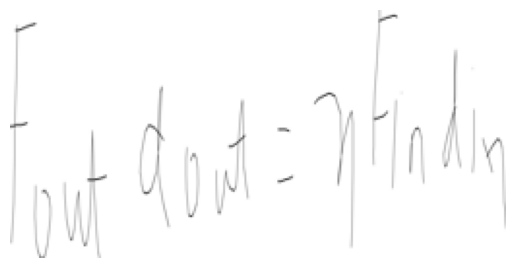

original size:  (1162, 163)
resized size:  (256, 128)


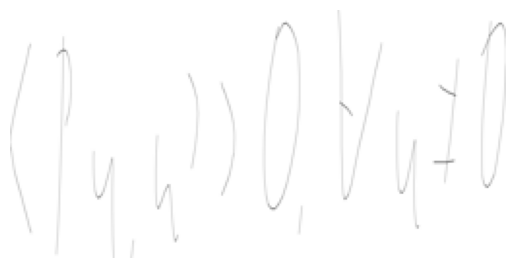

original size:  (2204, 278)
resized size:  (256, 128)


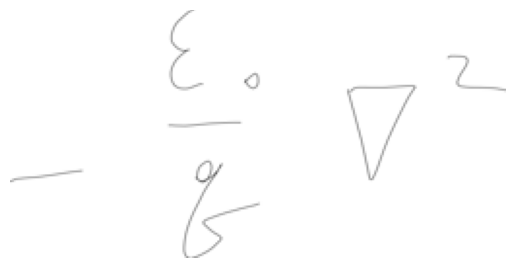

original size:  (672, 386)
resized size:  (256, 128)


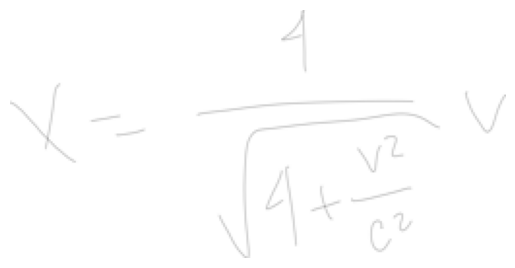

original size:  (1469, 694)
resized size:  (256, 128)


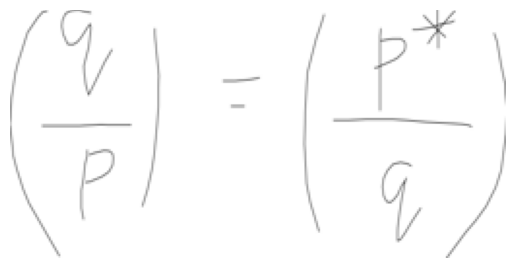

original size:  (682, 266)
resized size:  (256, 128)


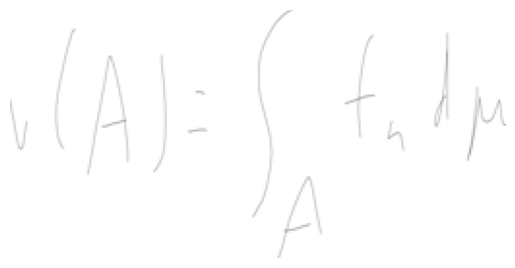

original size:  (1439, 450)
resized size:  (256, 128)


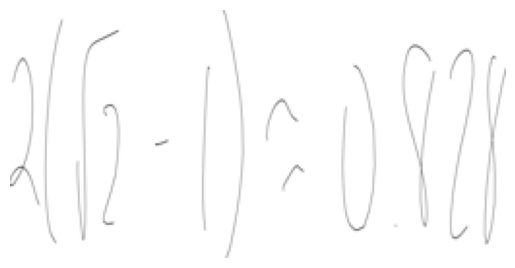

original size:  (1075, 227)
resized size:  (256, 128)


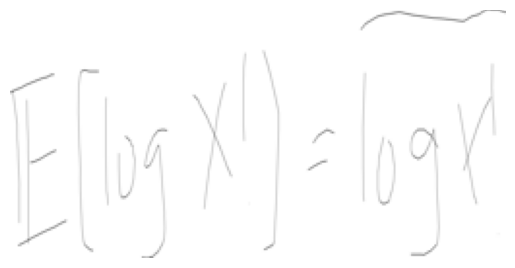

original size:  (1639, 303)
resized size:  (256, 128)


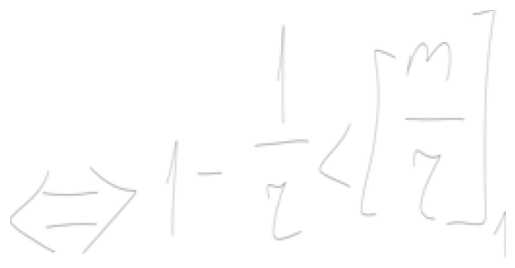

original size:  (1833, 498)
resized size:  (256, 128)


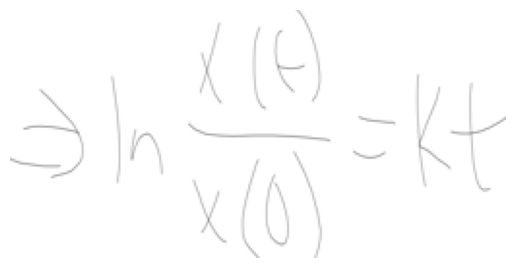

original size:  (1164, 380)
resized size:  (256, 128)


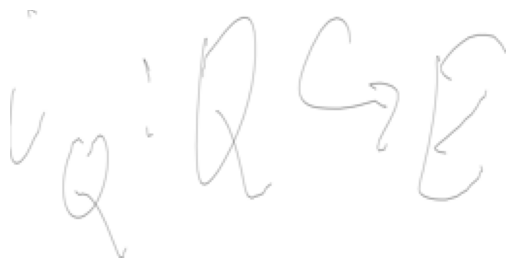

original size:  (1461, 389)
resized size:  (256, 128)


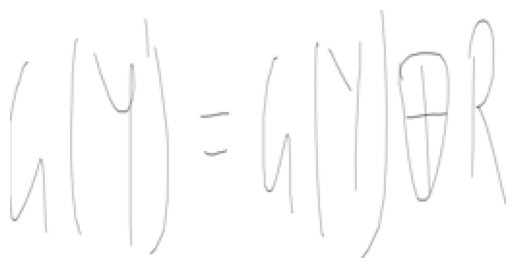

original size:  (1190, 259)
resized size:  (256, 128)


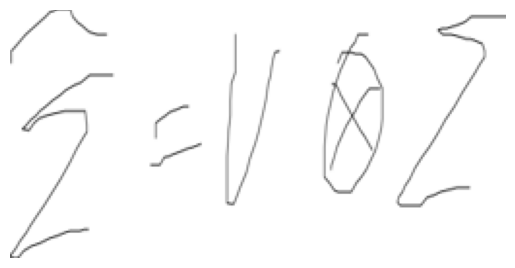

original size:  (591, 166)
resized size:  (256, 128)


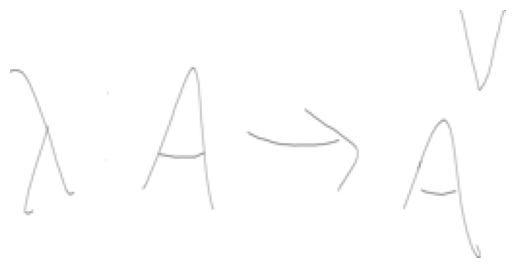

original size:  (1185, 313)
resized size:  (256, 128)


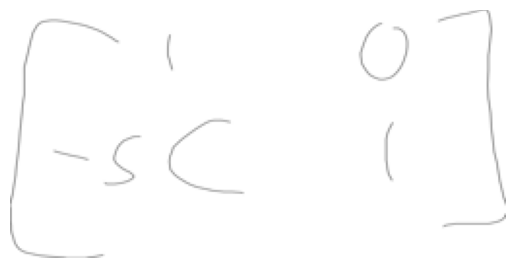

original size:  (684, 414)
resized size:  (256, 128)


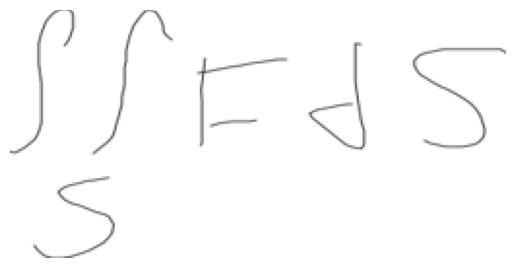

original size:  (346, 217)
resized size:  (256, 128)


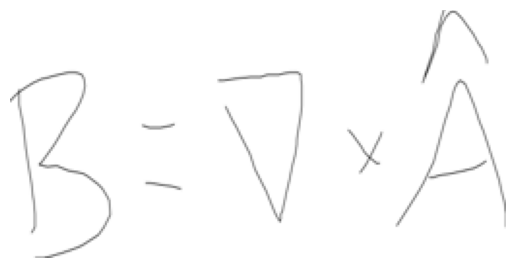

original size:  (595, 216)
resized size:  (256, 128)


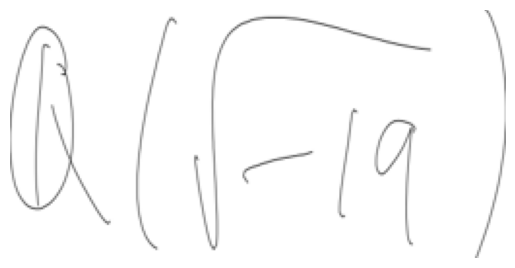

original size:  (570, 192)
resized size:  (256, 128)


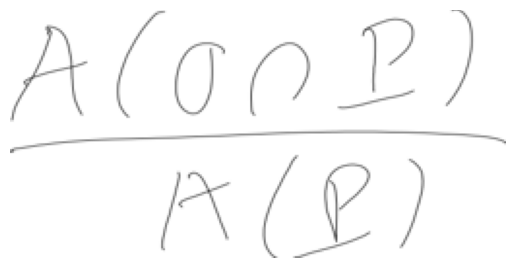

original size:  (437, 270)
resized size:  (256, 128)


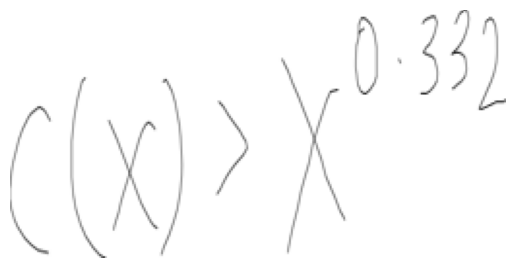

original size:  (667, 146)
resized size:  (256, 128)


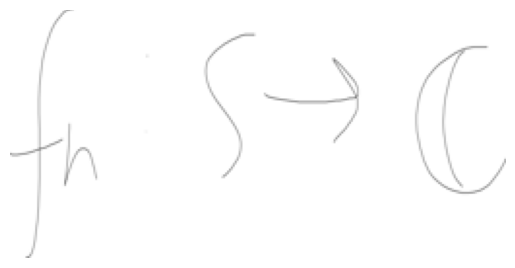

original size:  (975, 321)
resized size:  (256, 128)


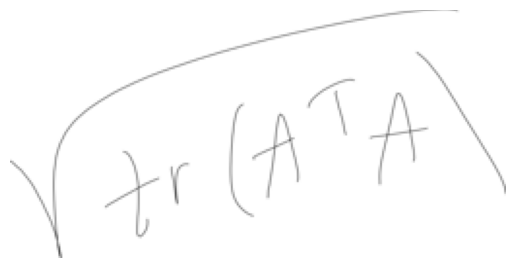

original size:  (641, 357)
resized size:  (256, 128)


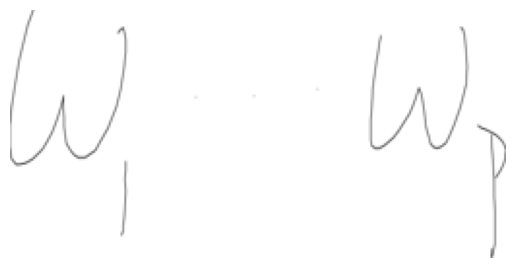

original size:  (587, 186)
resized size:  (256, 128)


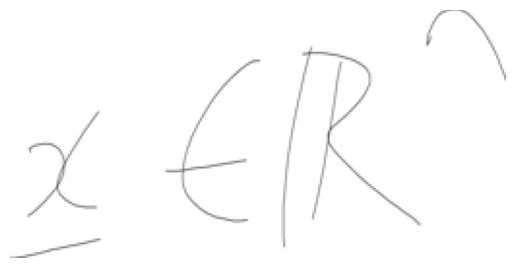

original size:  (693, 255)
resized size:  (256, 128)


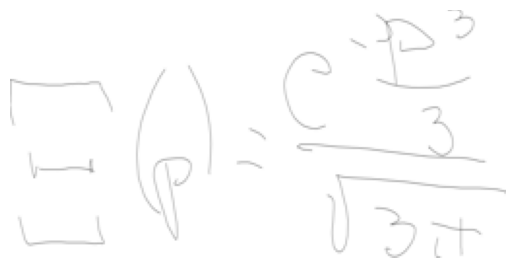

original size:  (1389, 484)
resized size:  (256, 128)


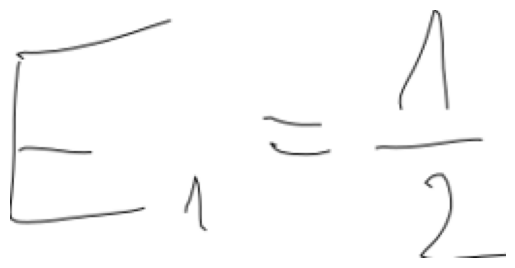

original size:  (285, 138)
resized size:  (256, 128)


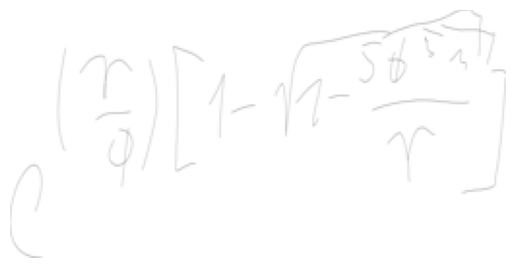

original size:  (2364, 691)
resized size:  (256, 128)


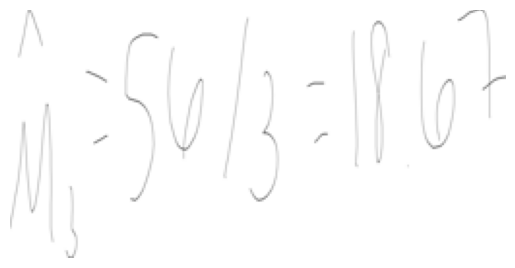

original size:  (1518, 245)
resized size:  (256, 128)


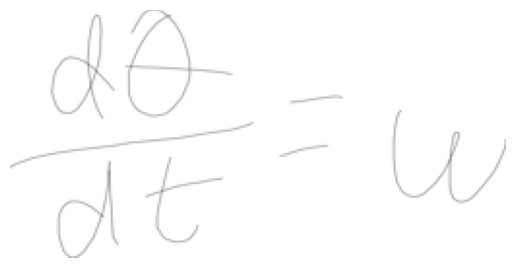

original size:  (876, 484)
resized size:  (256, 128)


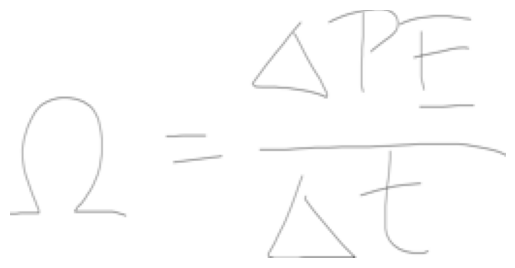

original size:  (955, 354)
resized size:  (256, 128)


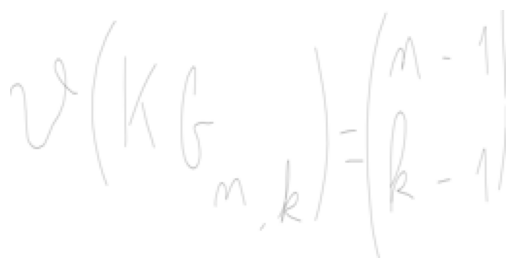

original size:  (2065, 600)
resized size:  (256, 128)


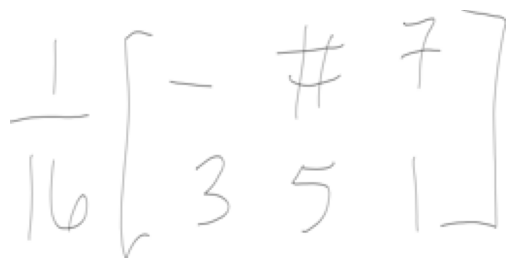

original size:  (1110, 311)
resized size:  (256, 128)


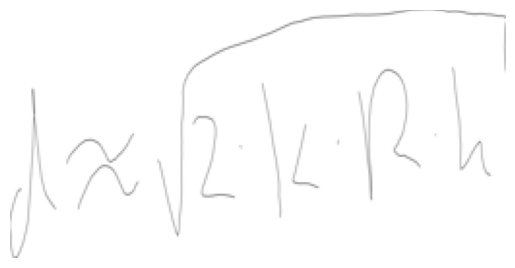

original size:  (1119, 318)
resized size:  (256, 128)


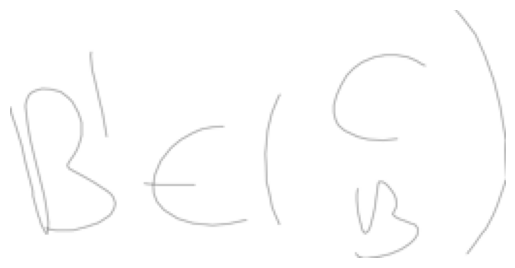

original size:  (928, 487)
resized size:  (256, 128)


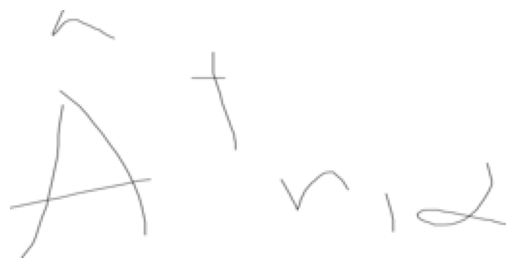

original size:  (554, 368)
resized size:  (256, 128)


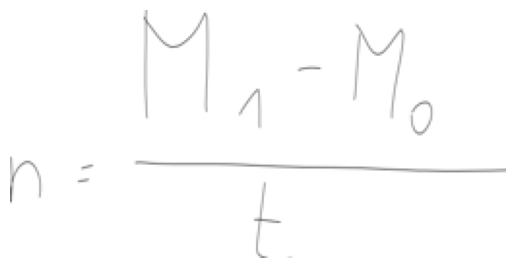

original size:  (778, 259)
resized size:  (256, 128)


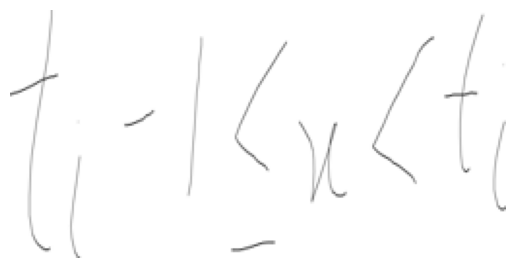

original size:  (916, 165)
resized size:  (256, 128)


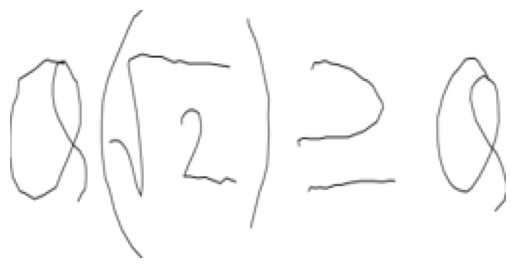

original size:  (528, 159)
resized size:  (256, 128)


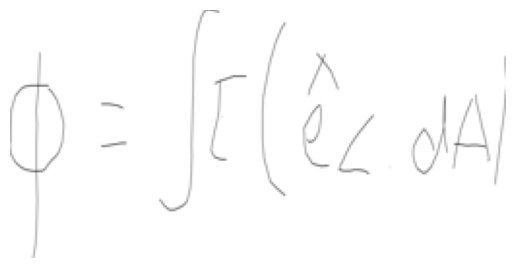

original size:  (899, 242)
resized size:  (256, 128)


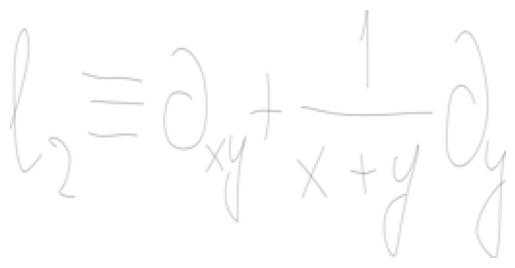

original size:  (1727, 594)
resized size:  (256, 128)


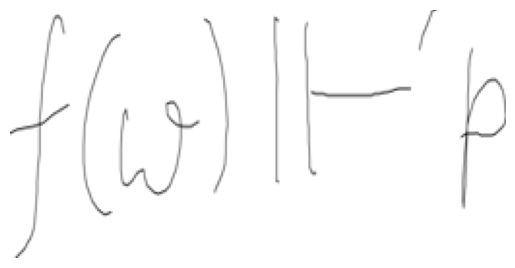

original size:  (586, 144)
resized size:  (256, 128)


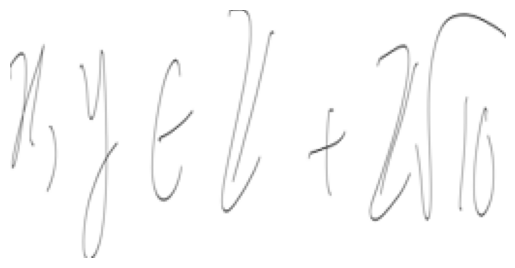

original size:  (961, 151)
resized size:  (256, 128)


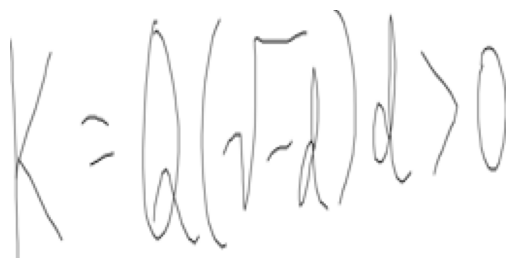

original size:  (641, 115)
resized size:  (256, 128)


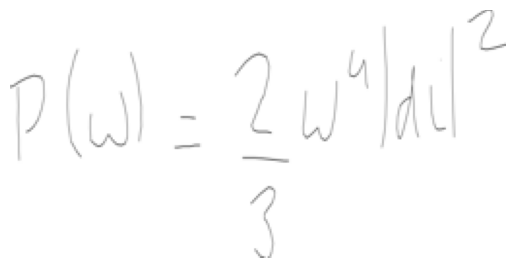

original size:  (1001, 239)
resized size:  (256, 128)


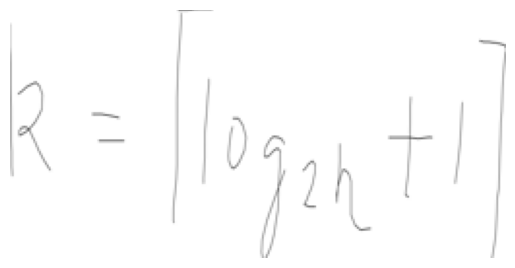

original size:  (837, 234)
resized size:  (256, 128)


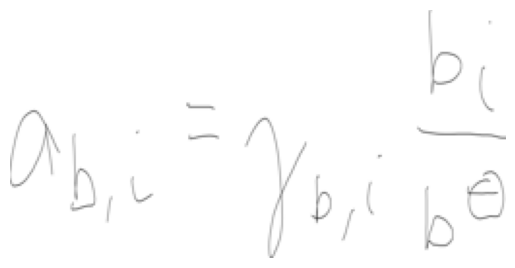

original size:  (942, 254)
resized size:  (256, 128)


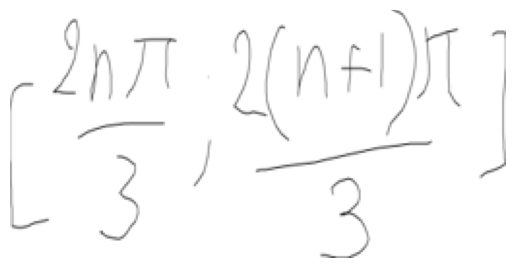

original size:  (697, 172)
resized size:  (256, 128)


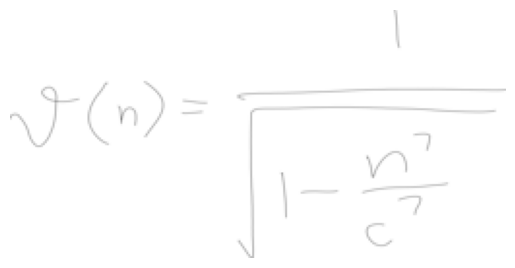

original size:  (978, 602)
resized size:  (256, 128)


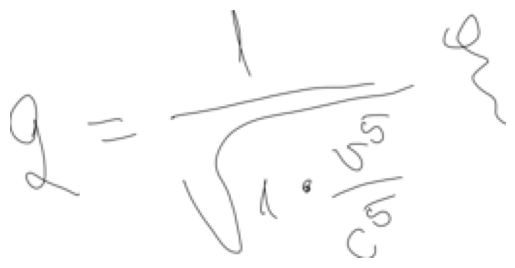

original size:  (509, 256)
resized size:  (256, 128)


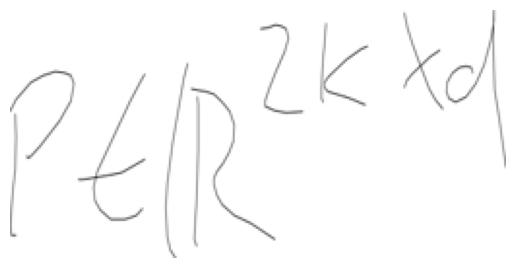

original size:  (659, 187)
resized size:  (256, 128)


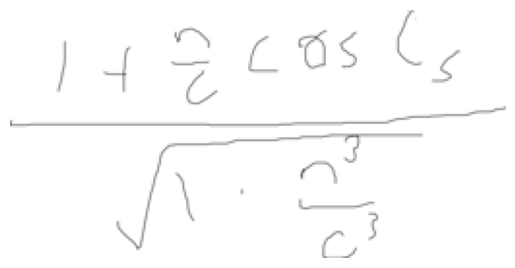

original size:  (579, 298)
resized size:  (256, 128)


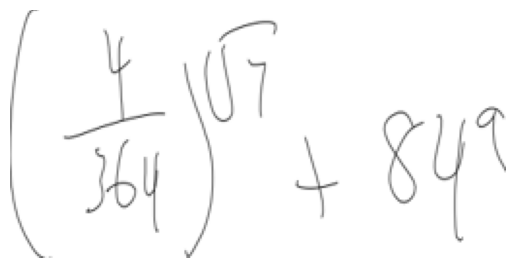

original size:  (496, 170)
resized size:  (256, 128)


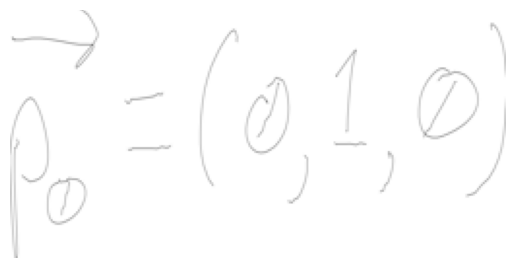

original size:  (1321, 426)
resized size:  (256, 128)


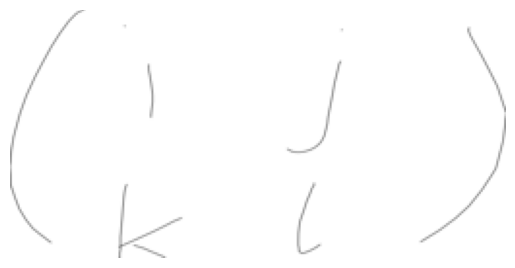

original size:  (633, 386)
resized size:  (256, 128)


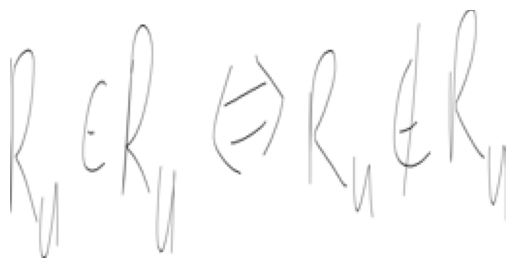

original size:  (1022, 157)
resized size:  (256, 128)


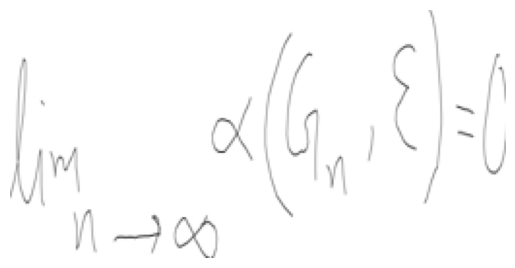

original size:  (890, 161)
resized size:  (256, 128)


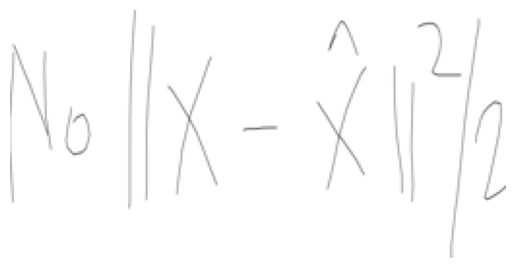

original size:  (851, 222)
resized size:  (256, 128)


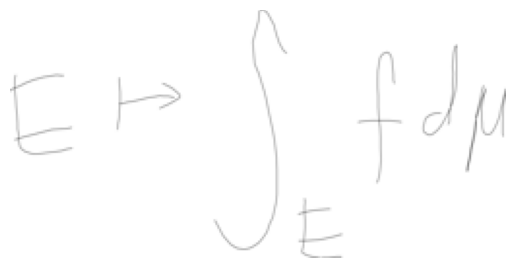

original size:  (1044, 470)
resized size:  (256, 128)


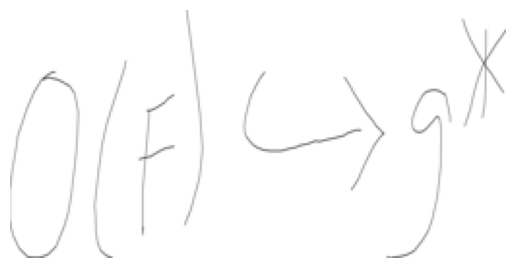

original size:  (963, 240)
resized size:  (256, 128)


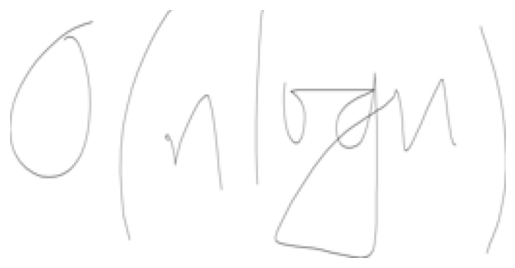

original size:  (1114, 314)
resized size:  (256, 128)


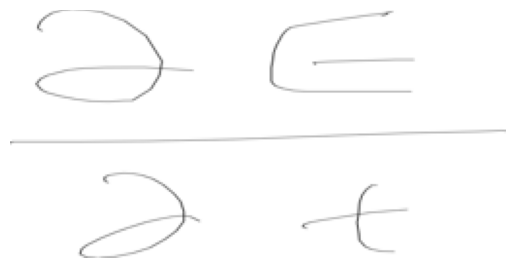

original size:  (376, 492)
resized size:  (256, 128)


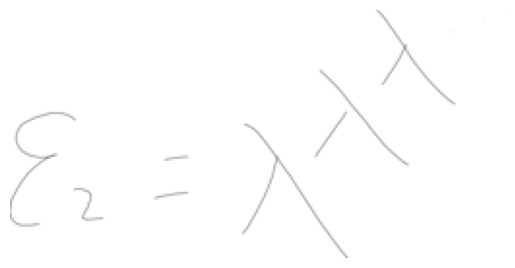

original size:  (842, 426)
resized size:  (256, 128)


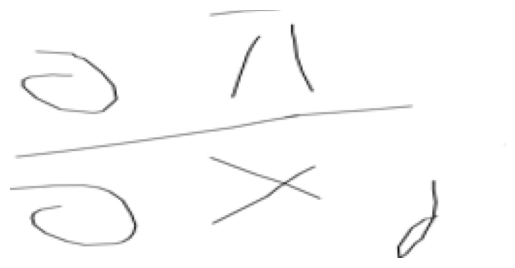

original size:  (224, 333)
resized size:  (256, 128)


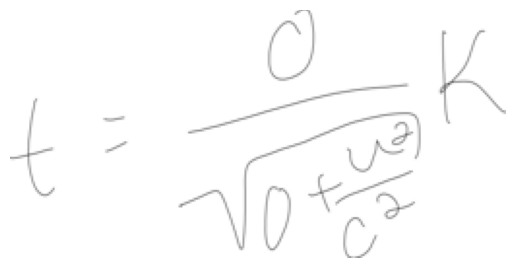

original size:  (693, 304)
resized size:  (256, 128)


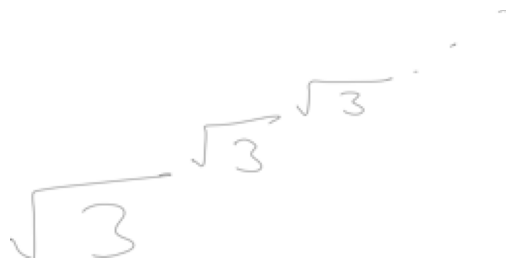

original size:  (879, 502)
resized size:  (256, 128)


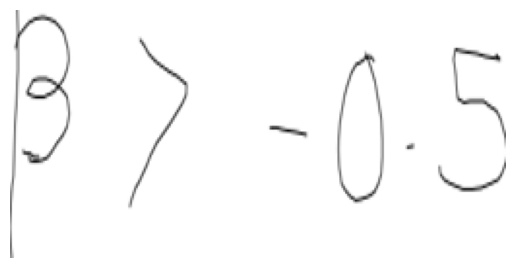

original size:  (438, 89)
resized size:  (256, 128)


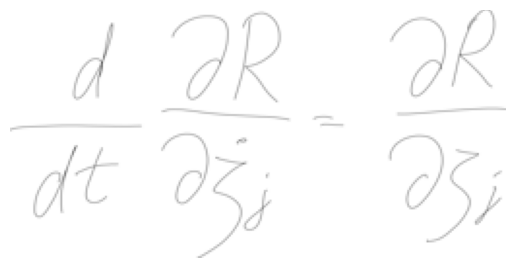

original size:  (907, 543)
resized size:  (256, 128)


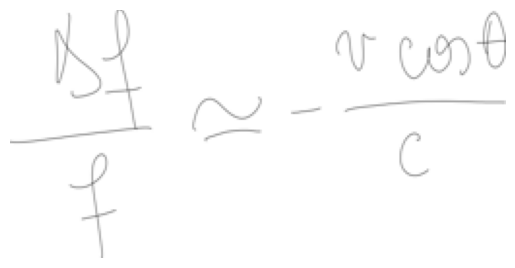

original size:  (818, 353)
resized size:  (256, 128)


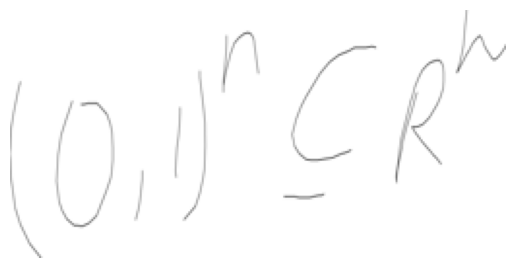

original size:  (906, 232)
resized size:  (256, 128)


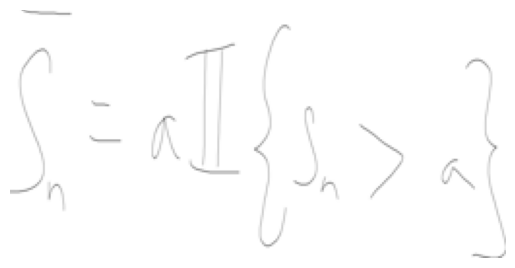

original size:  (1424, 308)
resized size:  (256, 128)


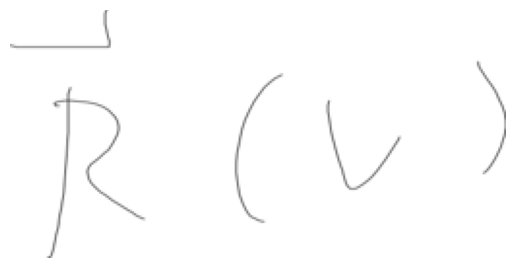

original size:  (443, 288)
resized size:  (256, 128)


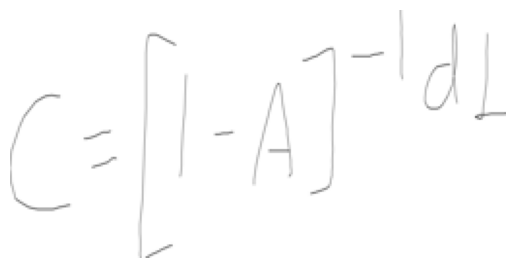

original size:  (986, 242)
resized size:  (256, 128)


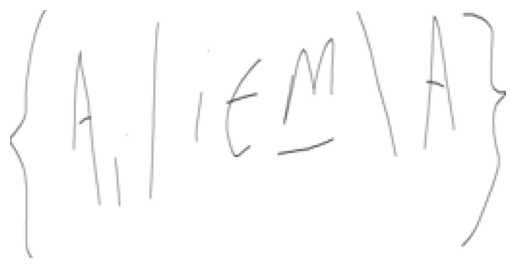

original size:  (776, 177)
resized size:  (256, 128)


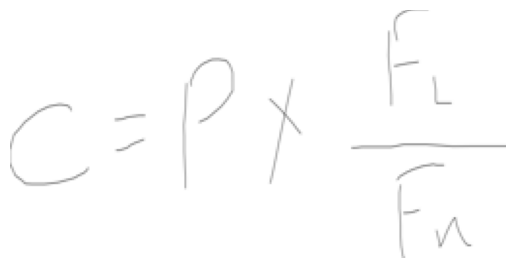

original size:  (859, 301)
resized size:  (256, 128)


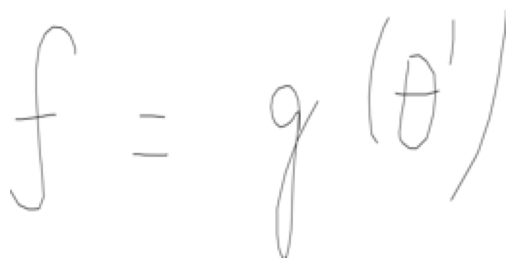

original size:  (658, 221)
resized size:  (256, 128)


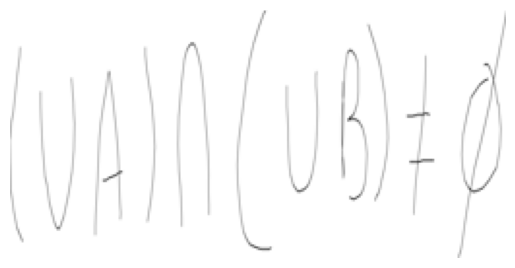

original size:  (1089, 174)
resized size:  (256, 128)


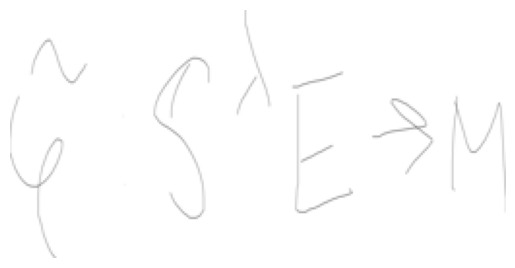

original size:  (1472, 390)
resized size:  (256, 128)


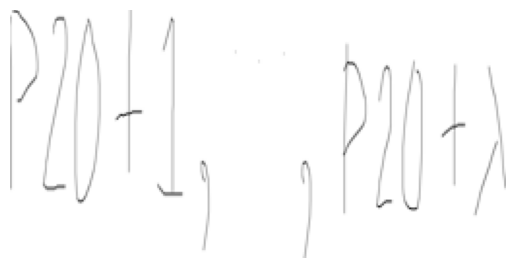

original size:  (975, 133)
resized size:  (256, 128)


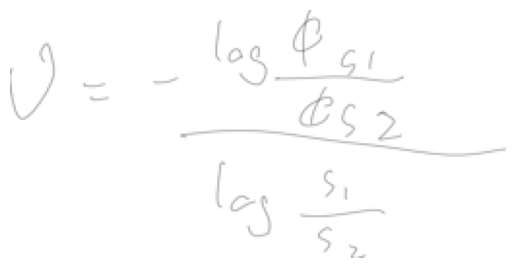

original size:  (860, 483)
resized size:  (256, 128)


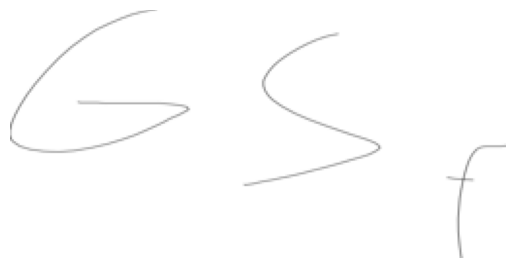

original size:  (591, 399)
resized size:  (256, 128)


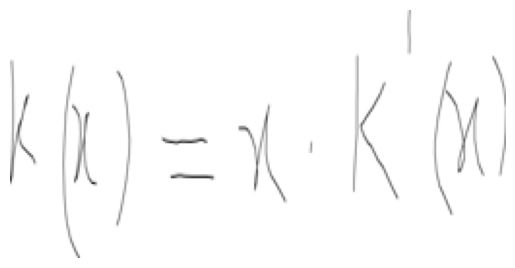

original size:  (671, 121)
resized size:  (256, 128)


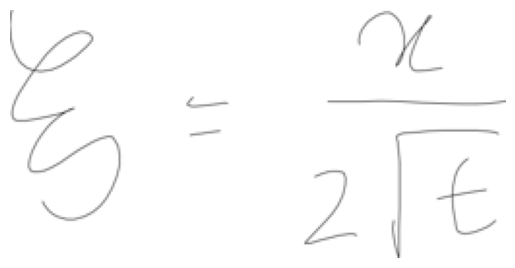

original size:  (576, 276)
resized size:  (256, 128)


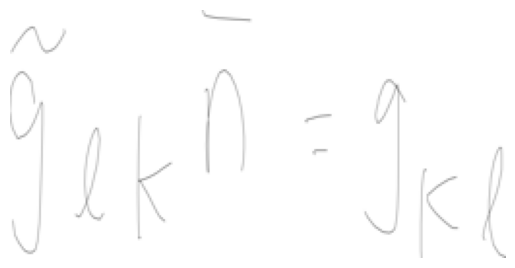

original size:  (1278, 356)
resized size:  (256, 128)


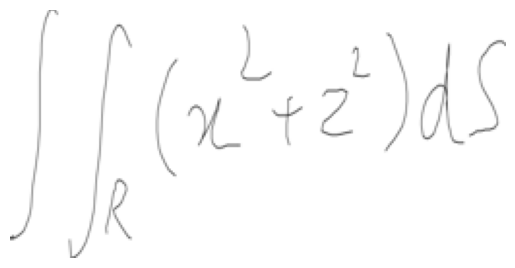

original size:  (681, 192)
resized size:  (256, 128)


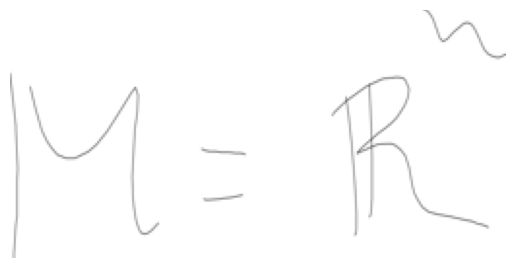

original size:  (763, 292)
resized size:  (256, 128)


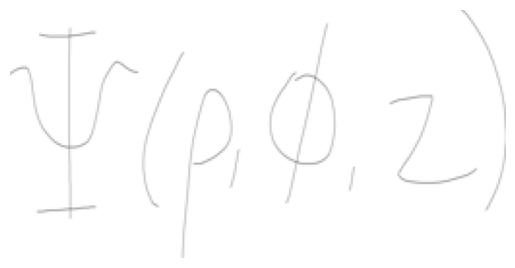

original size:  (1275, 391)
resized size:  (256, 128)


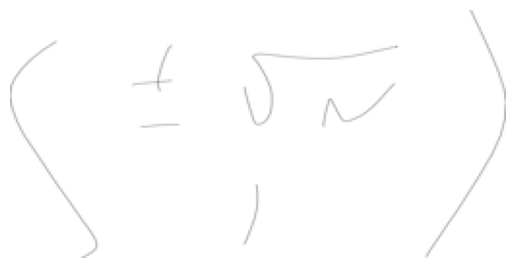

original size:  (928, 627)
resized size:  (256, 128)


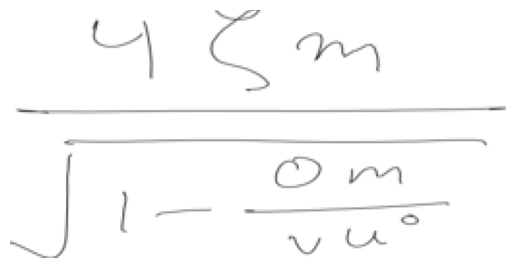

original size:  (360, 298)
resized size:  (256, 128)


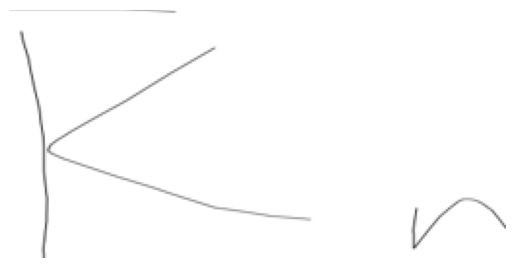

original size:  (350, 352)
resized size:  (256, 128)


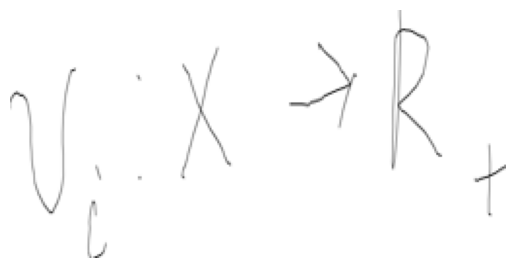

original size:  (763, 140)
resized size:  (256, 128)


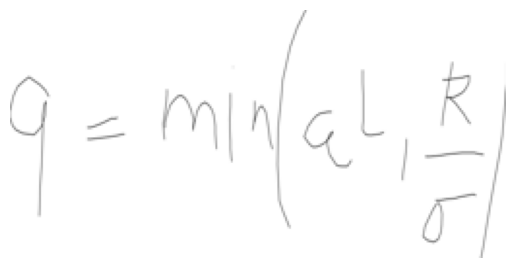

original size:  (780, 256)
resized size:  (256, 128)


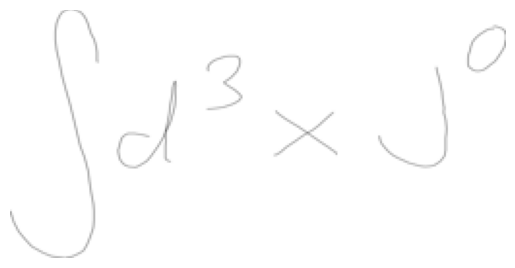

original size:  (798, 518)
resized size:  (256, 128)


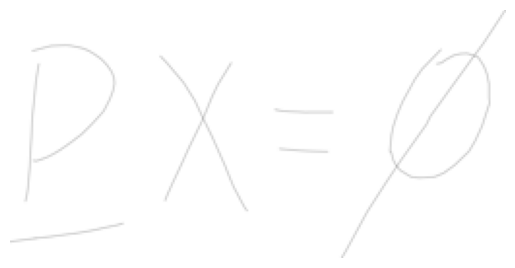

original size:  (1575, 789)
resized size:  (256, 128)


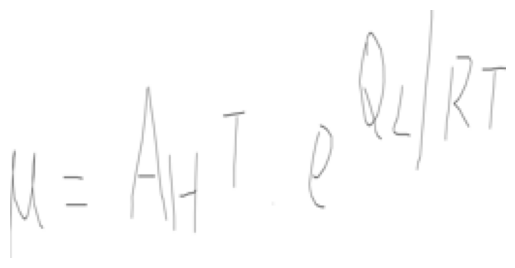

original size:  (968, 226)
resized size:  (256, 128)


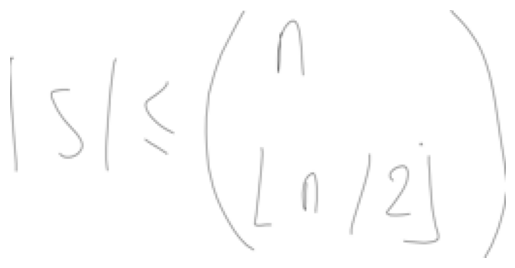

original size:  (806, 367)
resized size:  (256, 128)


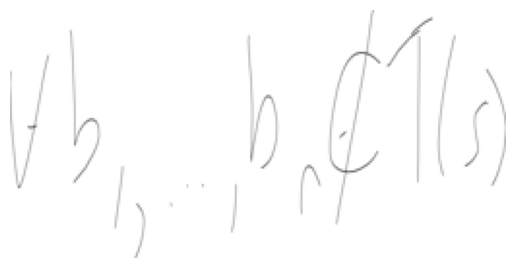

original size:  (1040, 214)
resized size:  (256, 128)


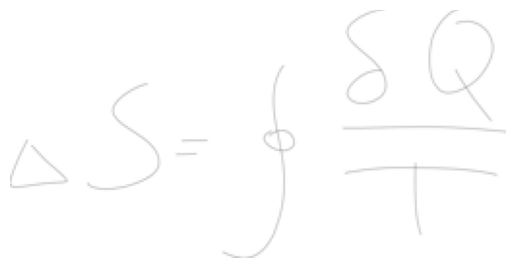

original size:  (1446, 703)
resized size:  (256, 128)


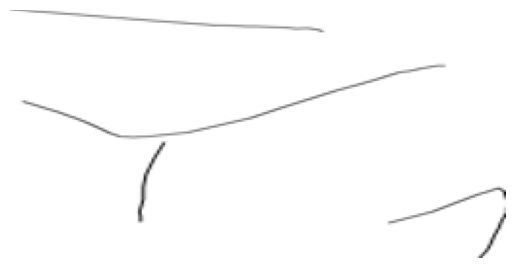

original size:  (189, 285)
resized size:  (256, 128)


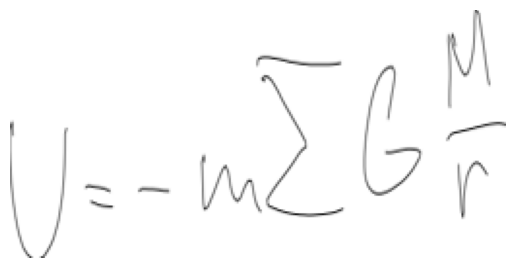

original size:  (505, 134)
resized size:  (256, 128)


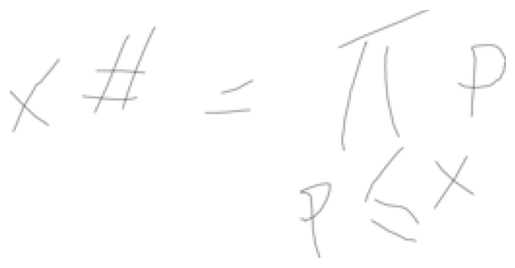

original size:  (759, 393)
resized size:  (256, 128)


In [11]:
# Assumes these files from mathwriting-2024-excerpt are available
# Assumes folder train-images exists
import os
path ='/cs230-root/MyDrive/cs230-project/mathwriting-2024-excerpt/'


def process_dir(infldr, outfldr):
  directory_files = os.listdir(infldr)
  nfiles = len(directory_files)

  for i in range(nfiles):
     f=infldr + '/' + directory_files[i]
     of=outfldr + '/' + directory_files[i] + ".rgb"
     strokes, annotations = read_inkml_file(f)
     img = render_ink(strokes, annotations)
     resized = img.resize((256,128))
     pl.axis('off')
     pl.imshow(resized)
     pl.show()
     print("original size: ", img.size)
     print("resized size: ", resized.size)
     img.save(of)

#
process_dir(path+'train/', path+'train-images/')

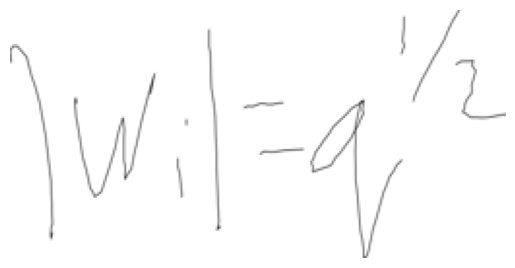

original size:  (524, 230)
resized size:  (256, 128)


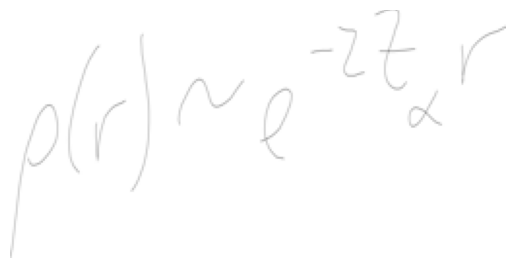

original size:  (1523, 467)
resized size:  (256, 128)


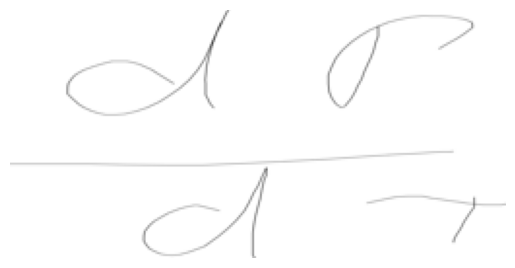

original size:  (578, 657)
resized size:  (256, 128)


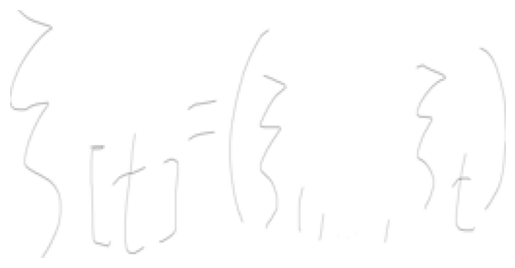

original size:  (2080, 497)
resized size:  (256, 128)


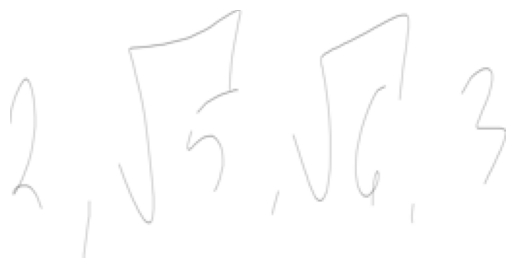

original size:  (1700, 451)
resized size:  (256, 128)


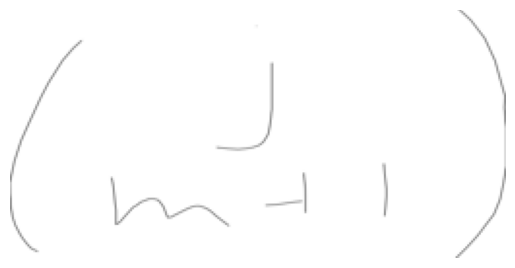

original size:  (576, 378)
resized size:  (256, 128)


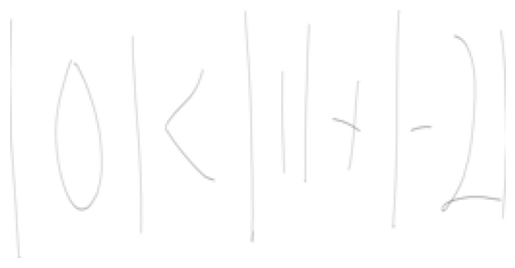

original size:  (2077, 477)
resized size:  (256, 128)


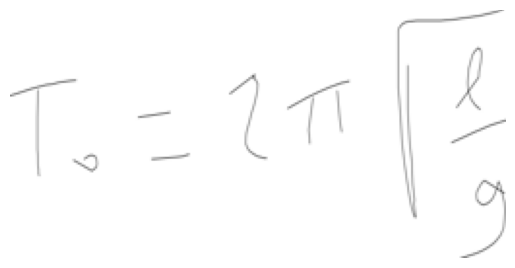

original size:  (780, 255)
resized size:  (256, 128)


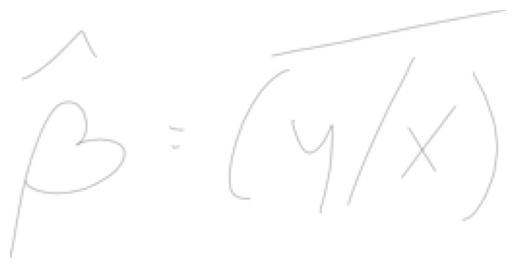

original size:  (1237, 633)
resized size:  (256, 128)


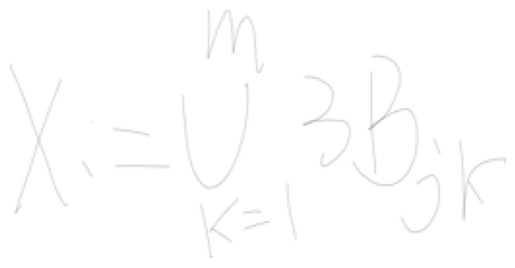

original size:  (2021, 806)
resized size:  (256, 128)


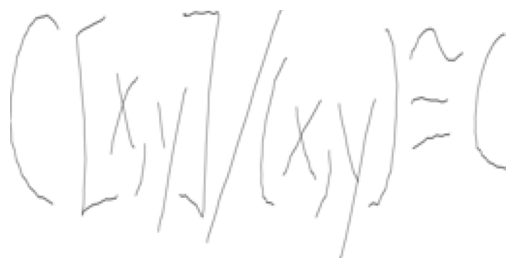

original size:  (895, 223)
resized size:  (256, 128)


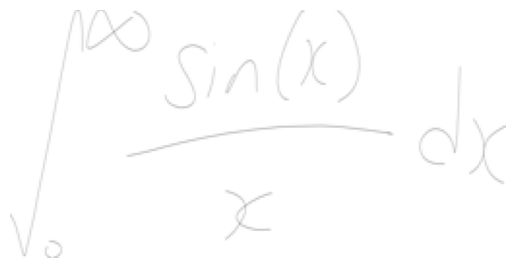

original size:  (1944, 594)
resized size:  (256, 128)


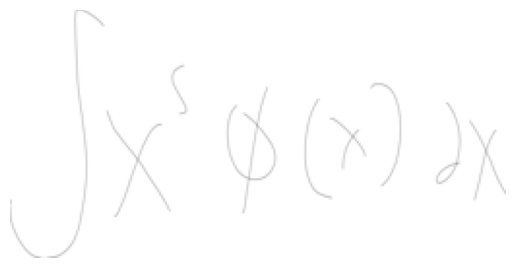

original size:  (1518, 606)
resized size:  (256, 128)


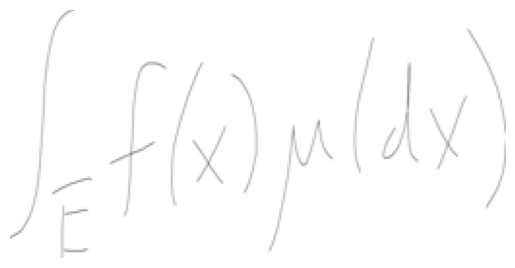

original size:  (1063, 316)
resized size:  (256, 128)


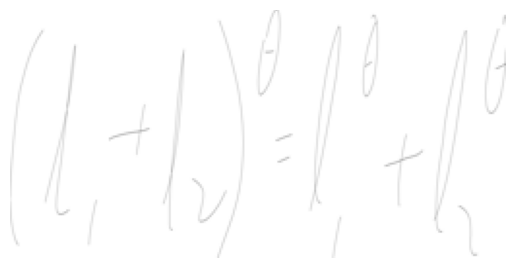

original size:  (2229, 542)
resized size:  (256, 128)


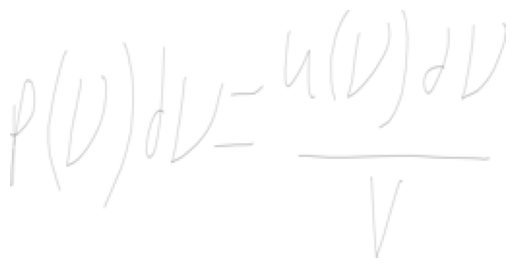

original size:  (2240, 636)
resized size:  (256, 128)


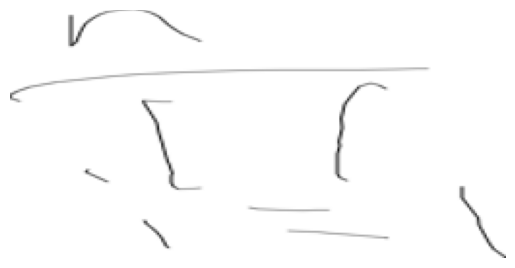

original size:  (203, 407)
resized size:  (256, 128)


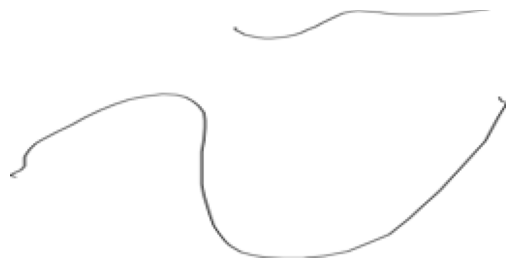

original size:  (275, 325)
resized size:  (256, 128)


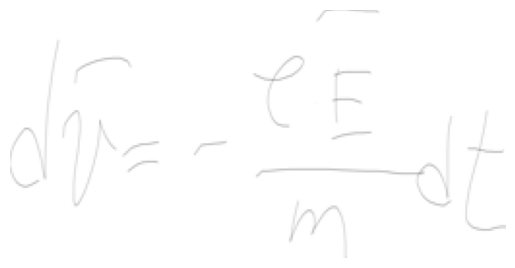

original size:  (2137, 558)
resized size:  (256, 128)


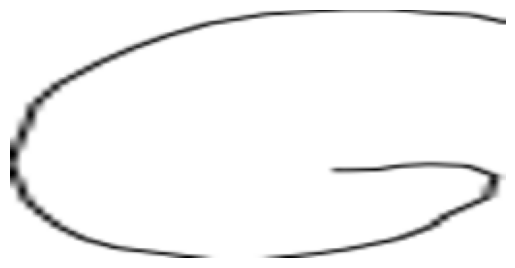

original size:  (60, 83)
resized size:  (256, 128)


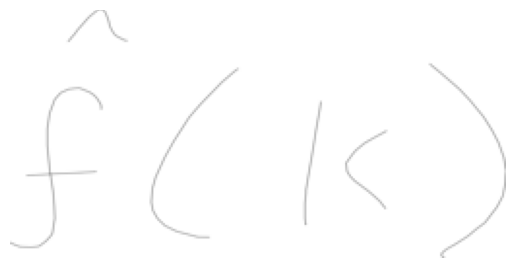

original size:  (930, 569)
resized size:  (256, 128)


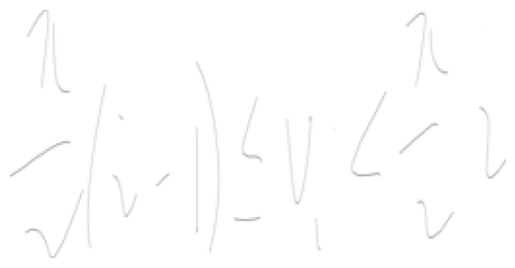

original size:  (2207, 403)
resized size:  (256, 128)


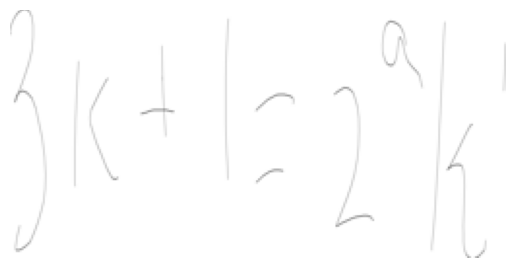

original size:  (1867, 323)
resized size:  (256, 128)


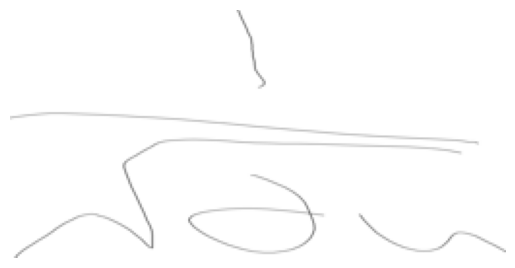

original size:  (516, 588)
resized size:  (256, 128)


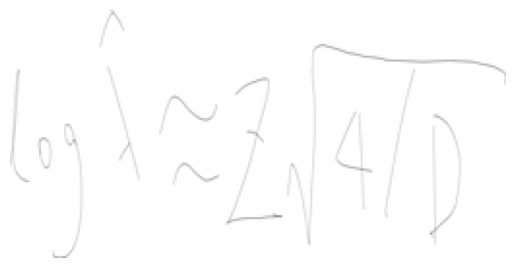

original size:  (2141, 424)
resized size:  (256, 128)


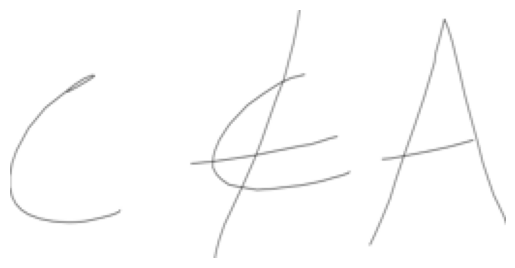

original size:  (685, 285)
resized size:  (256, 128)


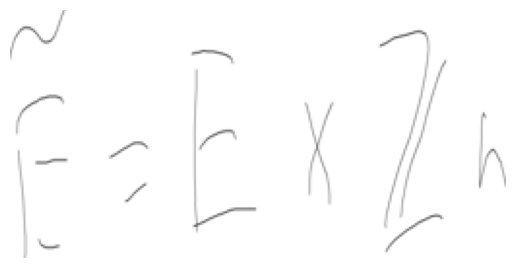

original size:  (897, 188)
resized size:  (256, 128)


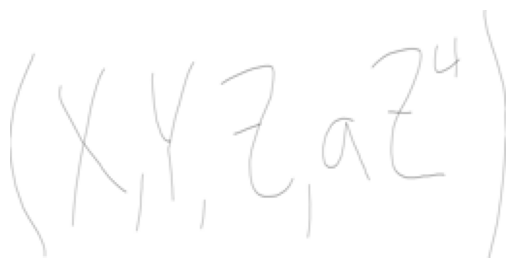

original size:  (1437, 450)
resized size:  (256, 128)


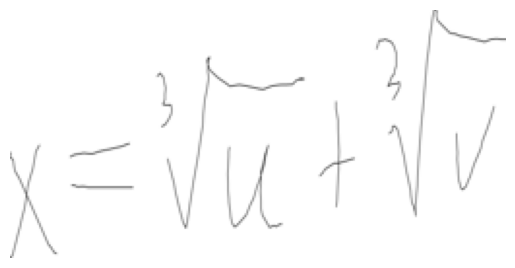

original size:  (707, 235)
resized size:  (256, 128)


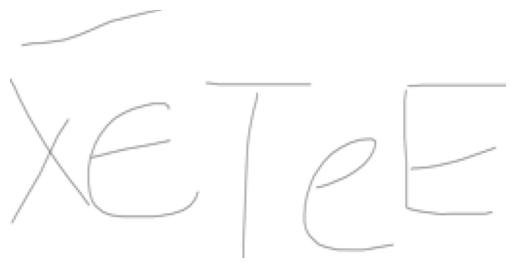

original size:  (796, 350)
resized size:  (256, 128)


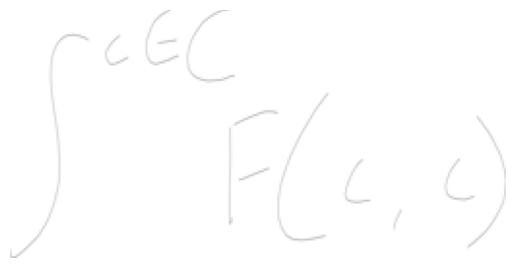

original size:  (1893, 582)
resized size:  (256, 128)


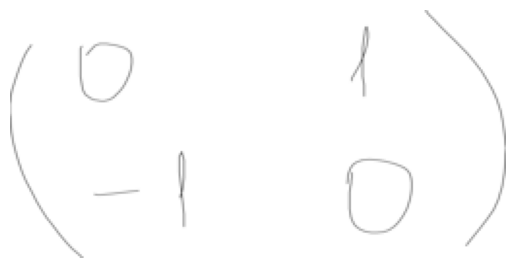

original size:  (647, 422)
resized size:  (256, 128)


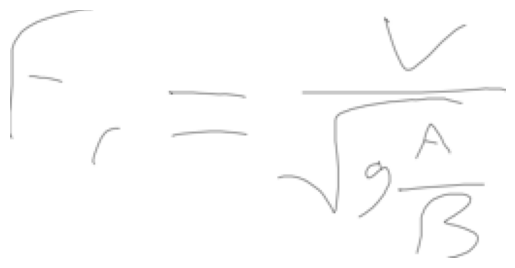

original size:  (693, 333)
resized size:  (256, 128)


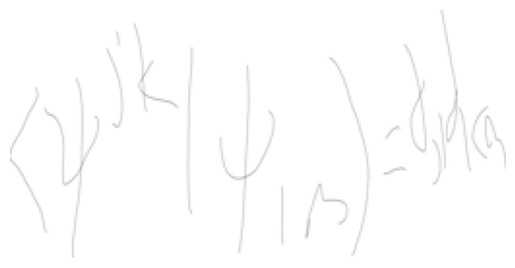

original size:  (1696, 536)
resized size:  (256, 128)


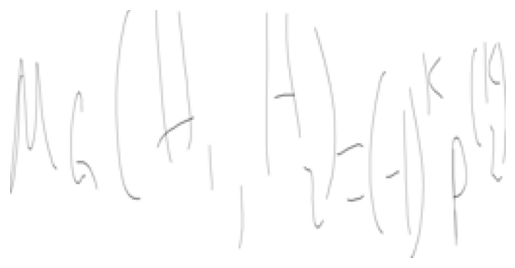

original size:  (1483, 252)
resized size:  (256, 128)


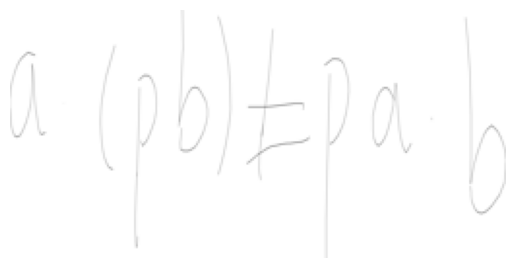

original size:  (2162, 430)
resized size:  (256, 128)


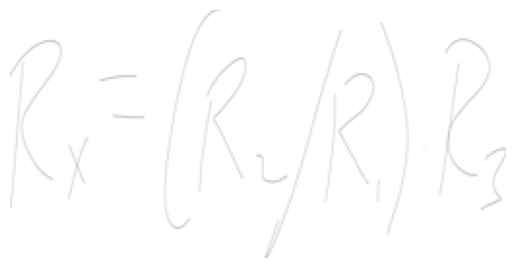

original size:  (2340, 579)
resized size:  (256, 128)


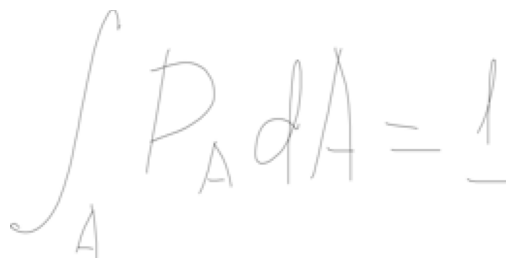

original size:  (1003, 437)
resized size:  (256, 128)


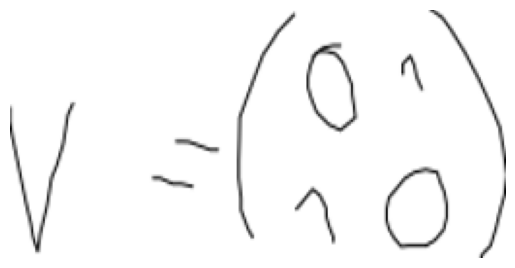

original size:  (214, 88)
resized size:  (256, 128)


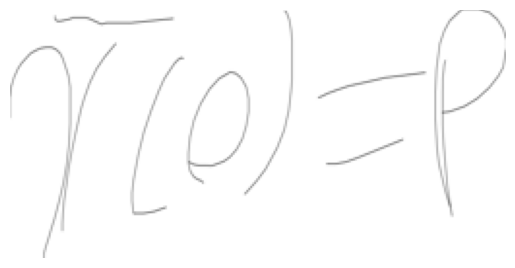

original size:  (889, 286)
resized size:  (256, 128)


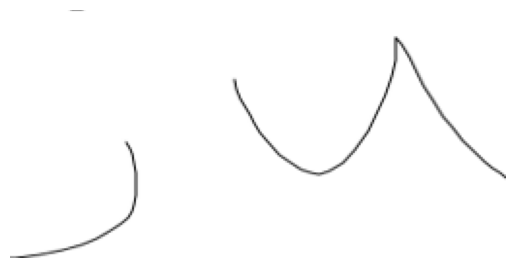

original size:  (252, 155)
resized size:  (256, 128)


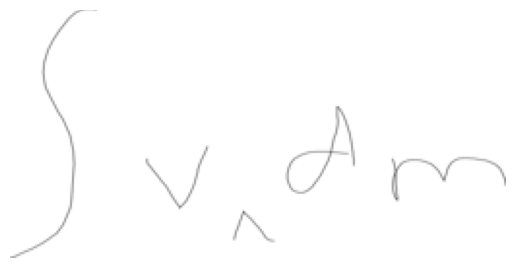

original size:  (626, 419)
resized size:  (256, 128)


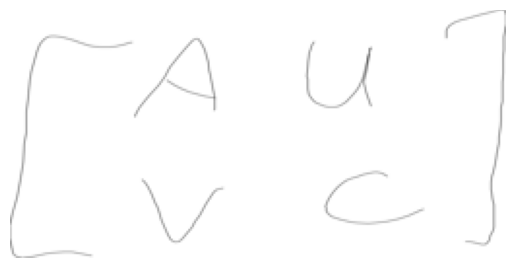

original size:  (698, 531)
resized size:  (256, 128)


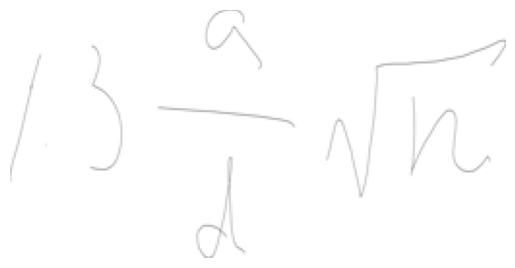

original size:  (1361, 436)
resized size:  (256, 128)


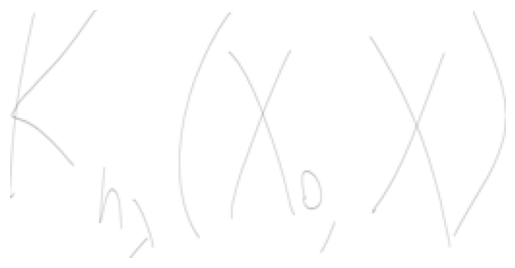

original size:  (2136, 557)
resized size:  (256, 128)


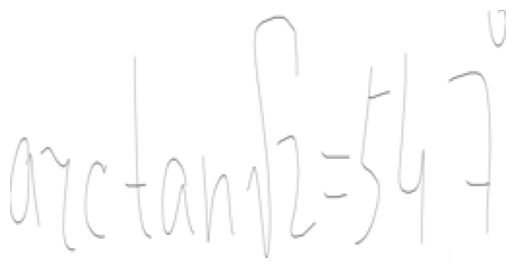

original size:  (1570, 269)
resized size:  (256, 128)


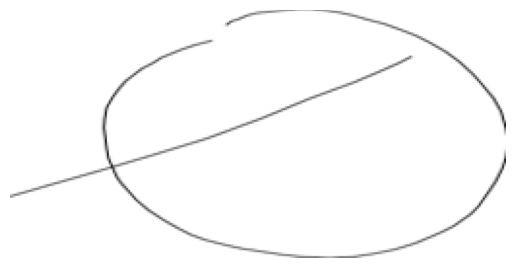

original size:  (236, 235)
resized size:  (256, 128)


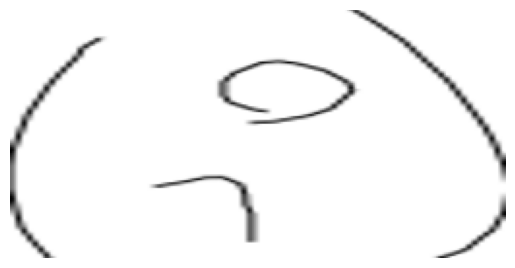

original size:  (88, 109)
resized size:  (256, 128)


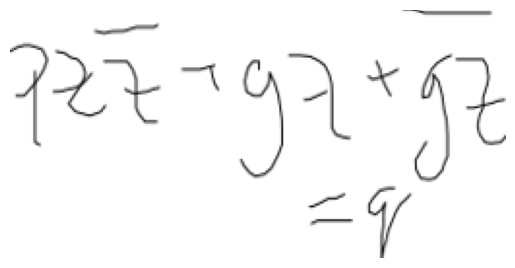

original size:  (278, 123)
resized size:  (256, 128)


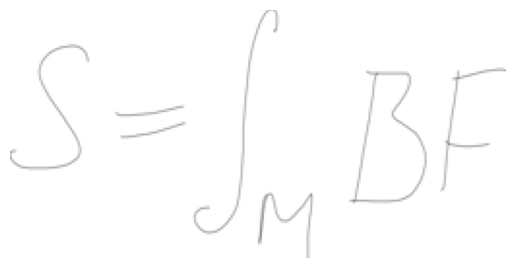

original size:  (912, 391)
resized size:  (256, 128)


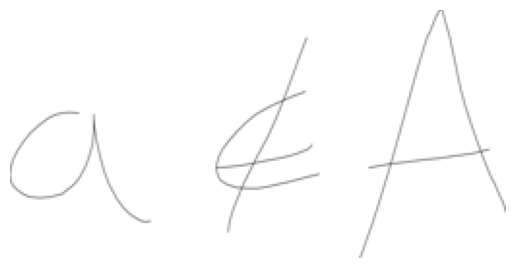

original size:  (727, 314)
resized size:  (256, 128)


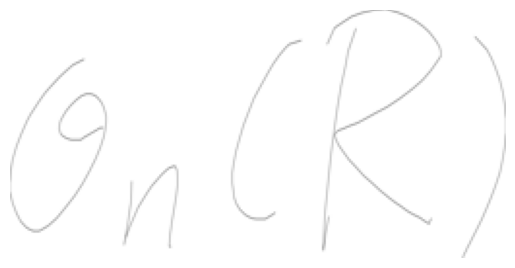

original size:  (1279, 396)
resized size:  (256, 128)


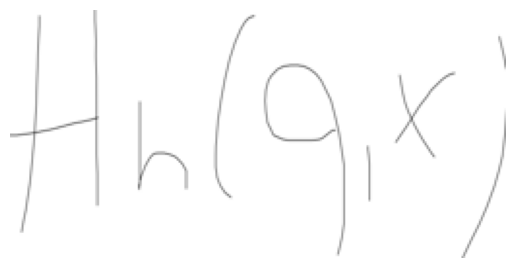

original size:  (641, 252)
resized size:  (256, 128)


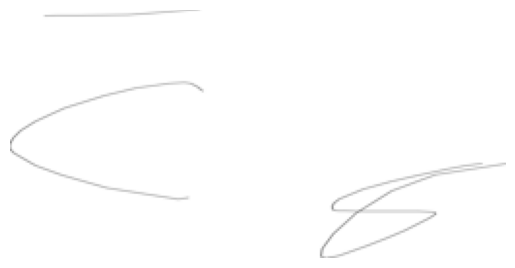

original size:  (583, 584)
resized size:  (256, 128)


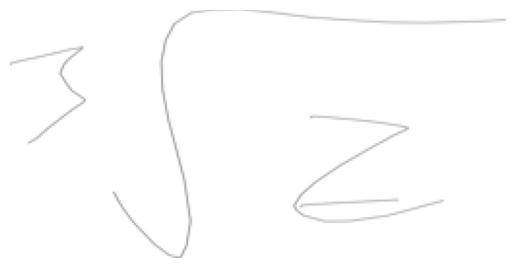

original size:  (709, 538)
resized size:  (256, 128)


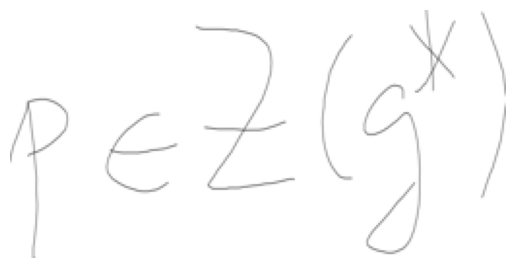

original size:  (810, 284)
resized size:  (256, 128)


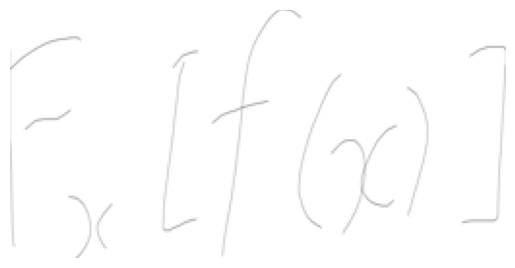

original size:  (1567, 434)
resized size:  (256, 128)


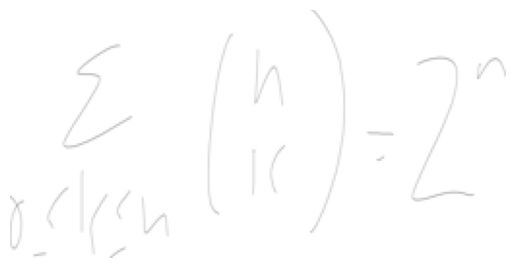

original size:  (1947, 515)
resized size:  (256, 128)


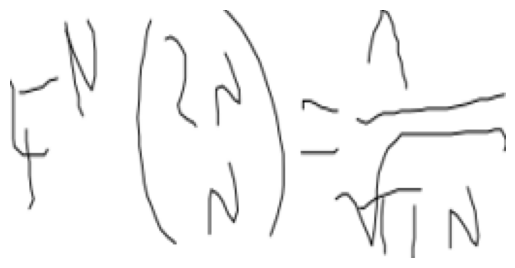

original size:  (302, 107)
resized size:  (256, 128)


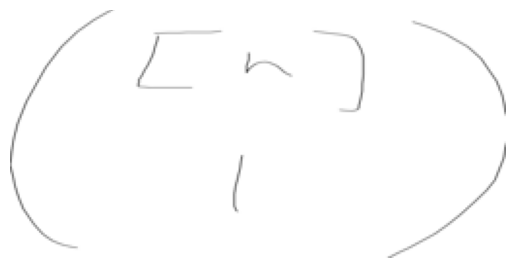

original size:  (442, 481)
resized size:  (256, 128)


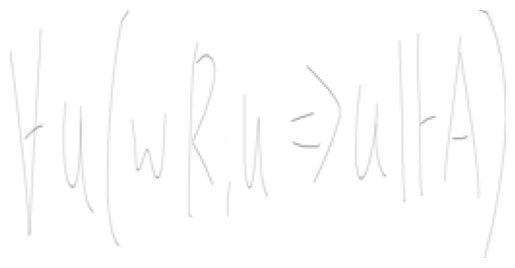

original size:  (2183, 369)
resized size:  (256, 128)


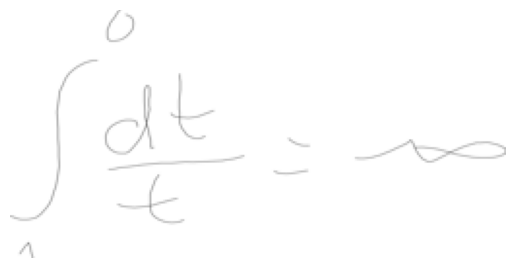

original size:  (856, 556)
resized size:  (256, 128)


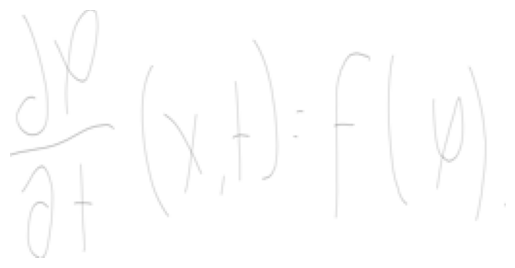

original size:  (2333, 625)
resized size:  (256, 128)


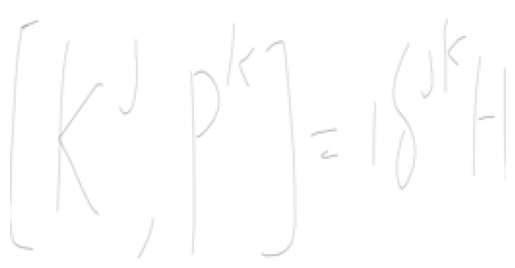

original size:  (2194, 530)
resized size:  (256, 128)


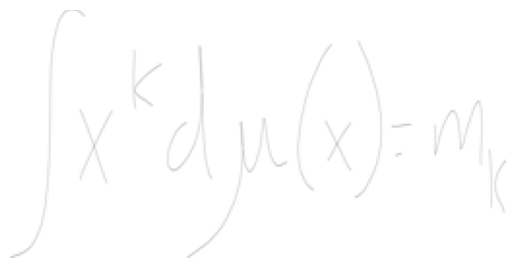

original size:  (2297, 649)
resized size:  (256, 128)


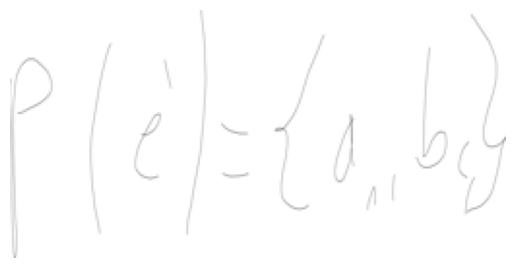

original size:  (1543, 448)
resized size:  (256, 128)


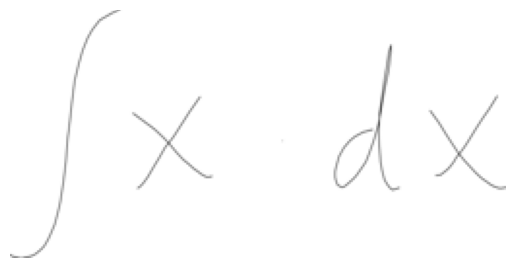

original size:  (621, 289)
resized size:  (256, 128)


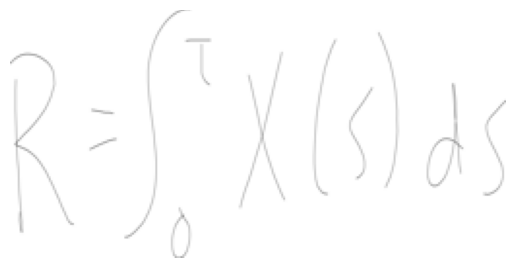

original size:  (1343, 392)
resized size:  (256, 128)


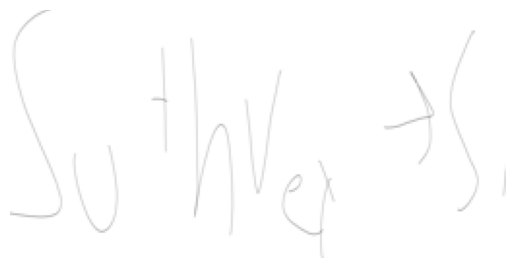

original size:  (1944, 514)
resized size:  (256, 128)


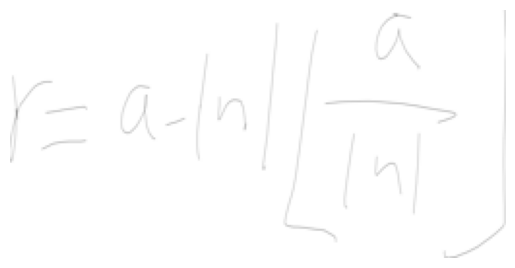

original size:  (2081, 643)
resized size:  (256, 128)


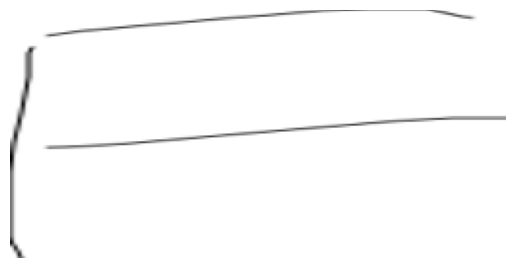

original size:  (132, 169)
resized size:  (256, 128)


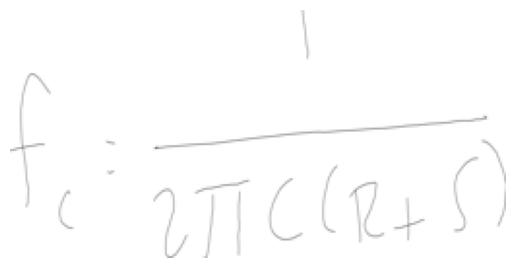

original size:  (1080, 390)
resized size:  (256, 128)


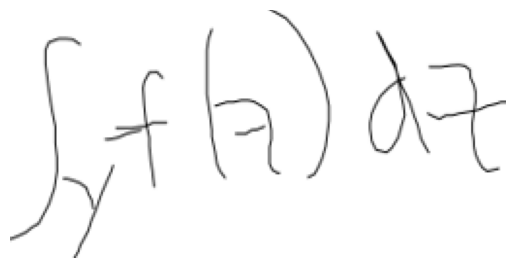

original size:  (300, 133)
resized size:  (256, 128)


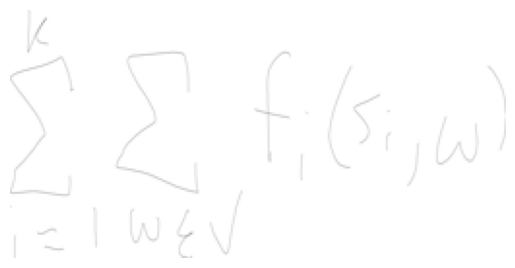

original size:  (2209, 702)
resized size:  (256, 128)


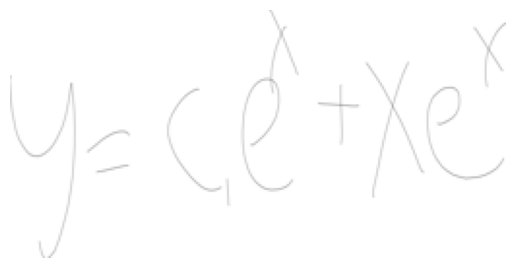

original size:  (1585, 525)
resized size:  (256, 128)


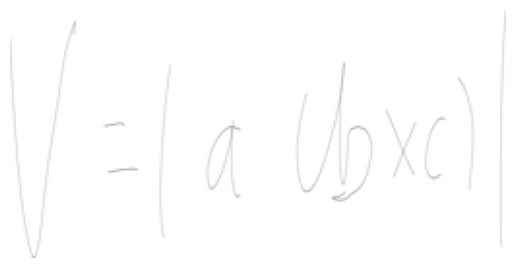

original size:  (2080, 464)
resized size:  (256, 128)


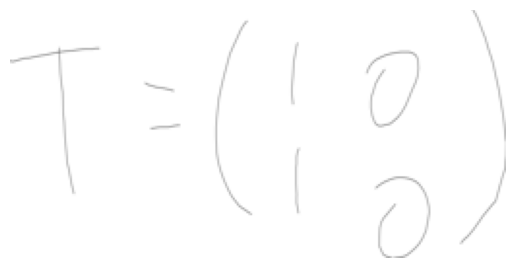

original size:  (1054, 411)
resized size:  (256, 128)


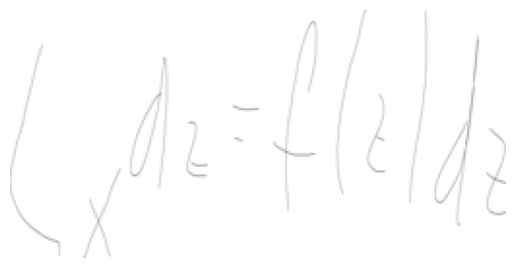

original size:  (1606, 406)
resized size:  (256, 128)


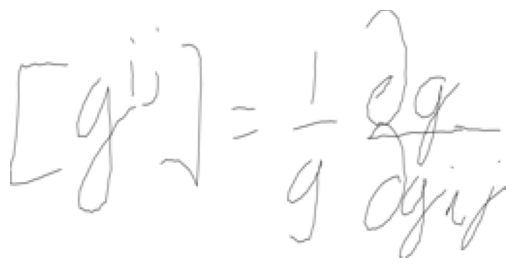

original size:  (759, 291)
resized size:  (256, 128)


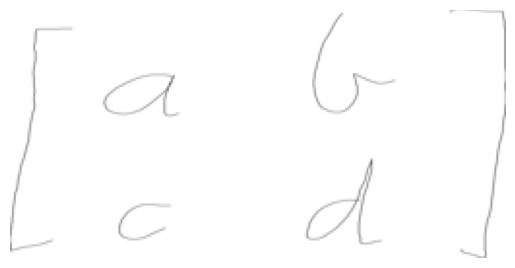

original size:  (661, 560)
resized size:  (256, 128)


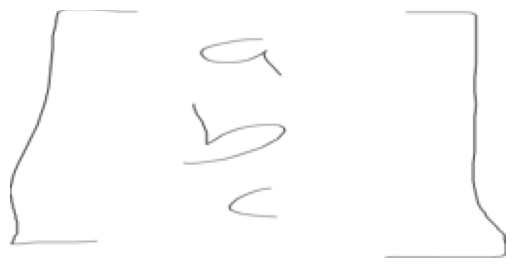

original size:  (348, 443)
resized size:  (256, 128)


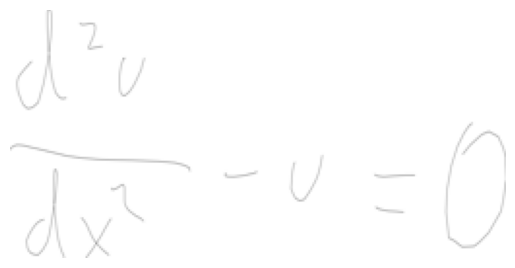

original size:  (1478, 536)
resized size:  (256, 128)


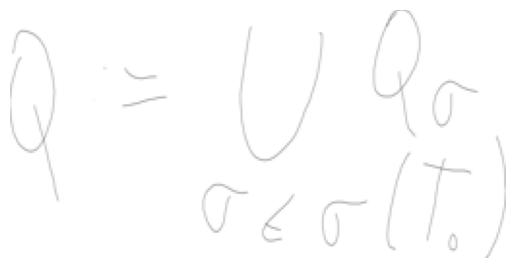

original size:  (1315, 444)
resized size:  (256, 128)


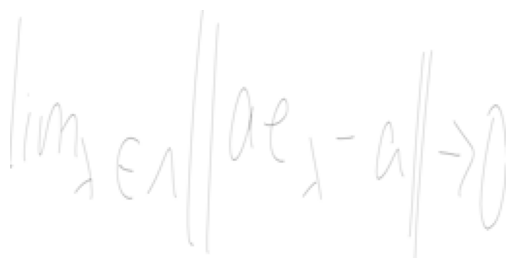

original size:  (2475, 534)
resized size:  (256, 128)


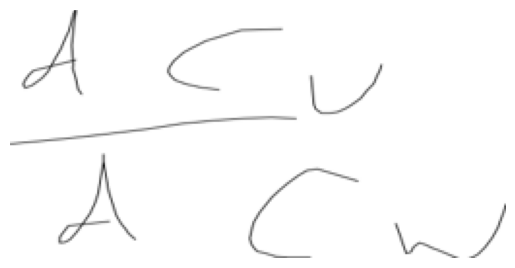

original size:  (339, 234)
resized size:  (256, 128)


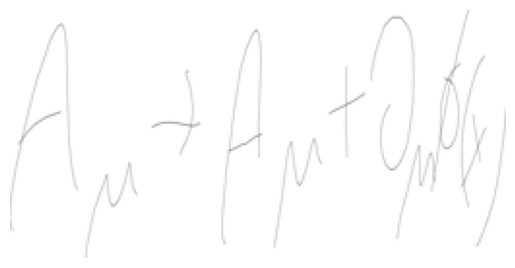

original size:  (1641, 388)
resized size:  (256, 128)


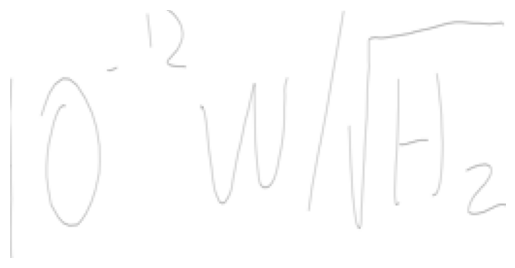

original size:  (1692, 490)
resized size:  (256, 128)


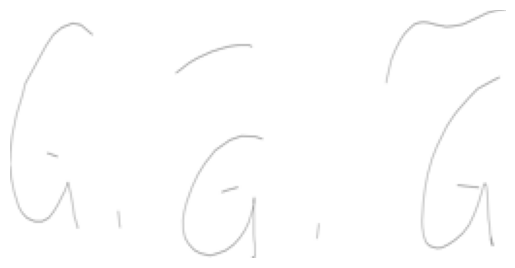

original size:  (1306, 435)
resized size:  (256, 128)


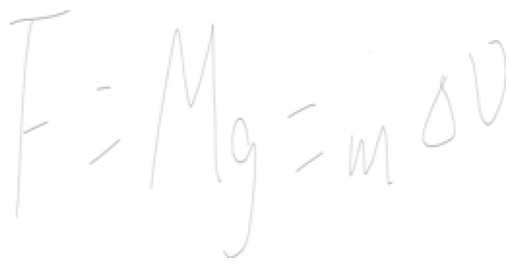

original size:  (2114, 489)
resized size:  (256, 128)


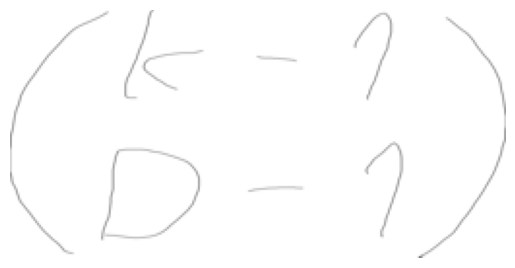

original size:  (674, 555)
resized size:  (256, 128)


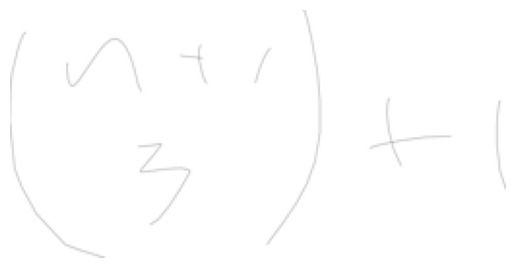

original size:  (1520, 758)
resized size:  (256, 128)


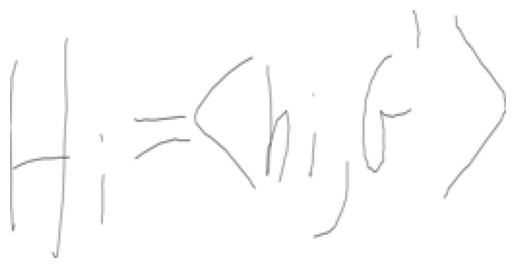

original size:  (748, 246)
resized size:  (256, 128)


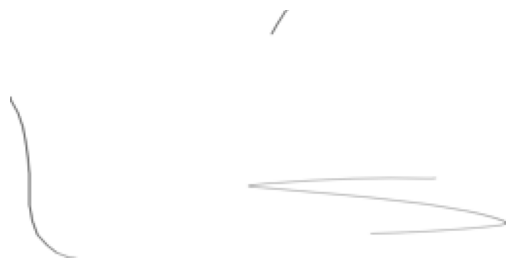

original size:  (429, 595)
resized size:  (256, 128)


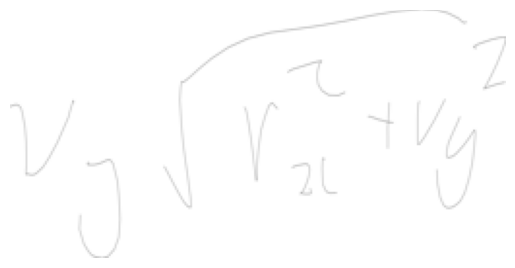

original size:  (1870, 676)
resized size:  (256, 128)


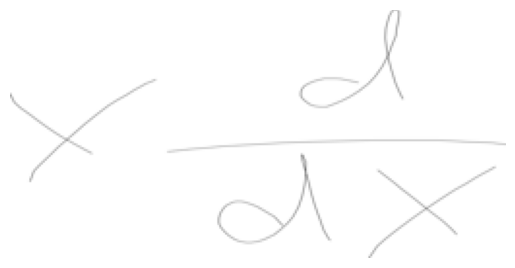

original size:  (793, 677)
resized size:  (256, 128)


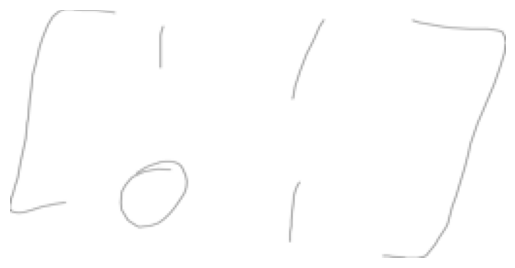

original size:  (774, 462)
resized size:  (256, 128)


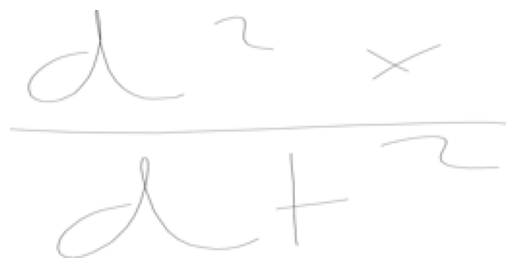

original size:  (787, 709)
resized size:  (256, 128)


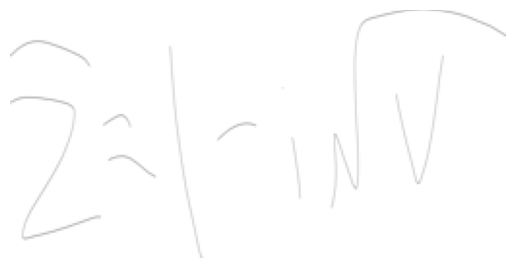

original size:  (1809, 499)
resized size:  (256, 128)


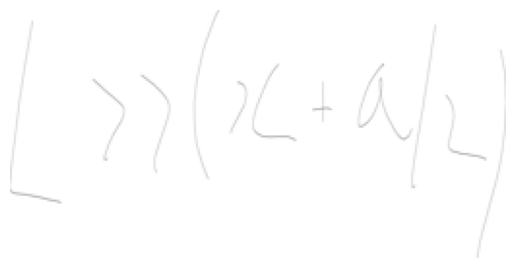

original size:  (2206, 482)
resized size:  (256, 128)


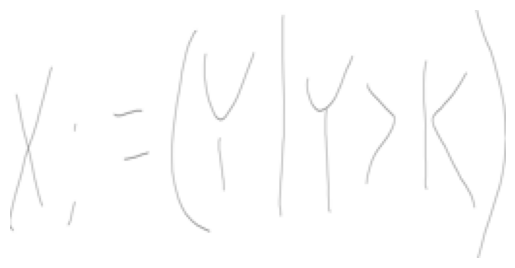

original size:  (1262, 355)
resized size:  (256, 128)


In [12]:
process_dir(path+'valid/', path+'valid-images/')

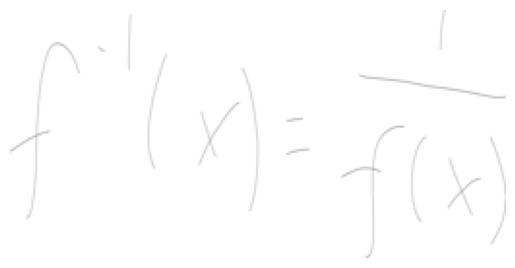

original size:  (1733, 527)
resized size:  (256, 128)


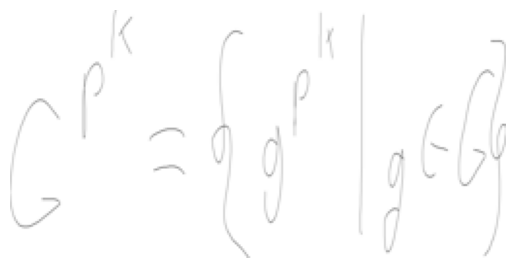

original size:  (1589, 334)
resized size:  (256, 128)


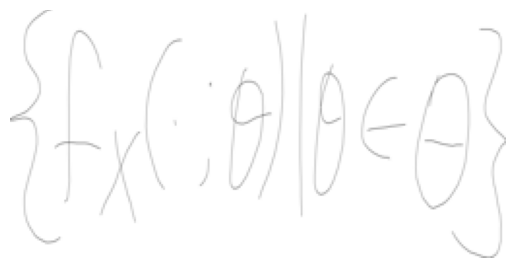

original size:  (1524, 416)
resized size:  (256, 128)


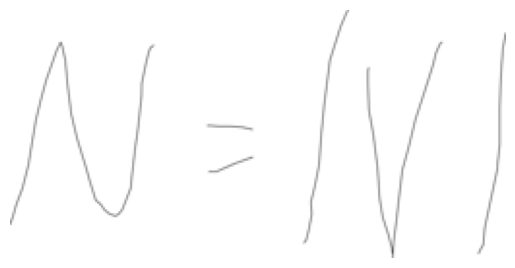

original size:  (636, 314)
resized size:  (256, 128)


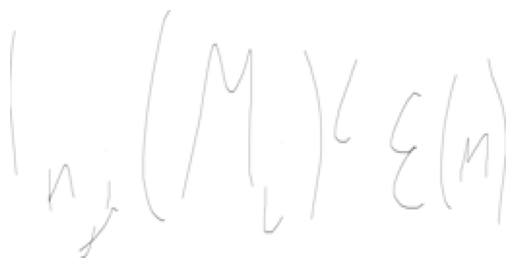

original size:  (1611, 358)
resized size:  (256, 128)


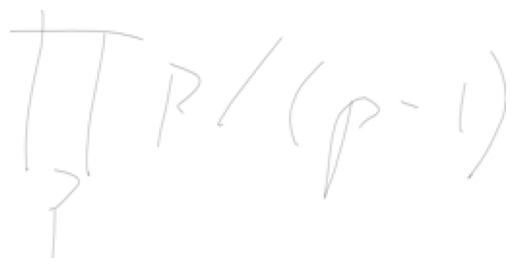

original size:  (1564, 654)
resized size:  (256, 128)


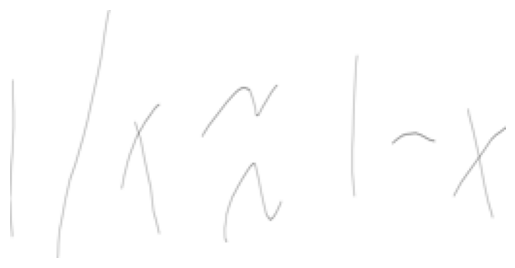

original size:  (1372, 326)
resized size:  (256, 128)


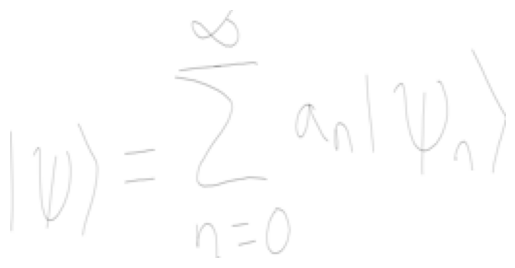

original size:  (2120, 590)
resized size:  (256, 128)


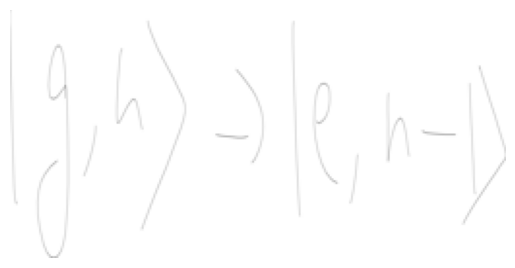

original size:  (2174, 486)
resized size:  (256, 128)


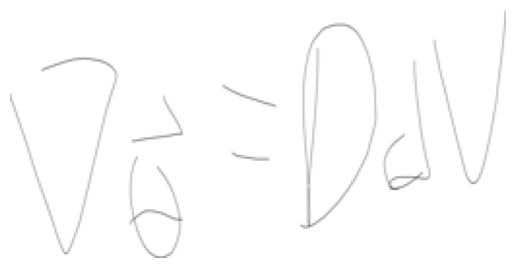

original size:  (1107, 317)
resized size:  (256, 128)


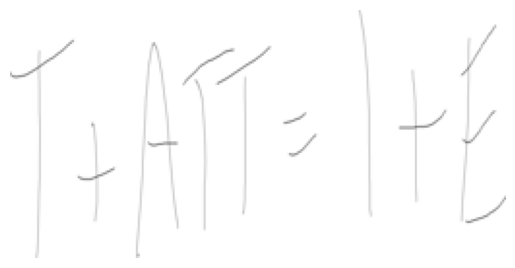

original size:  (1436, 256)
resized size:  (256, 128)


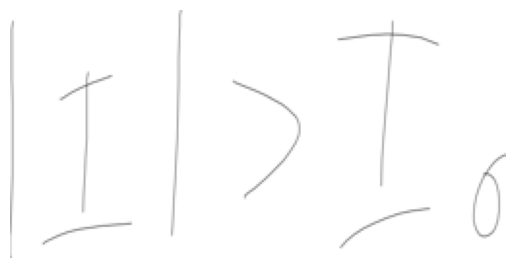

original size:  (800, 287)
resized size:  (256, 128)


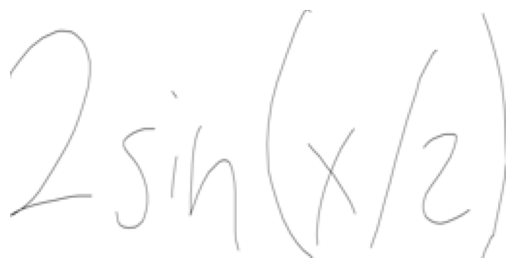

original size:  (881, 279)
resized size:  (256, 128)


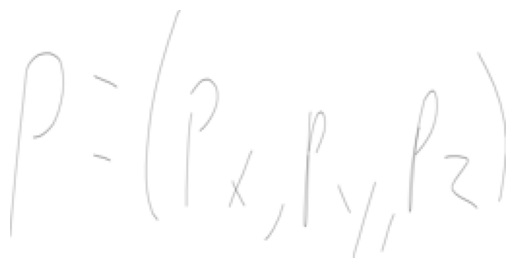

original size:  (1439, 404)
resized size:  (256, 128)


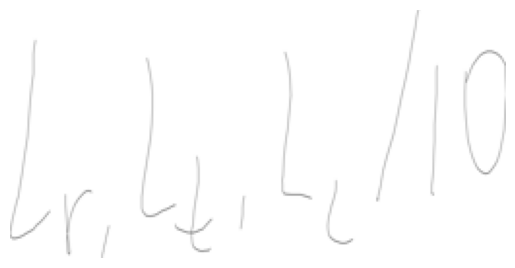

original size:  (1254, 334)
resized size:  (256, 128)


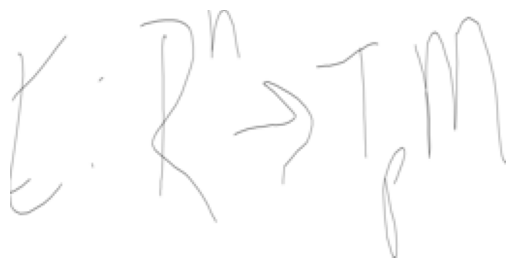

original size:  (1088, 332)
resized size:  (256, 128)


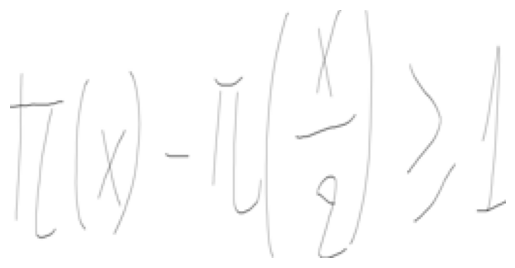

original size:  (1347, 242)
resized size:  (256, 128)


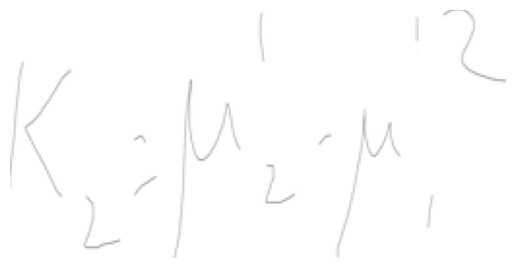

original size:  (1312, 381)
resized size:  (256, 128)


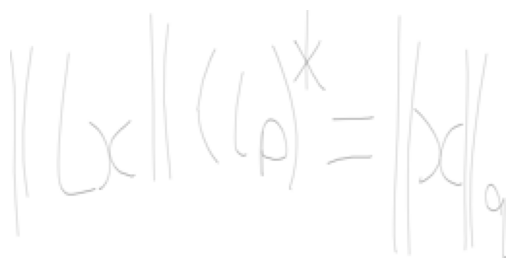

original size:  (2282, 501)
resized size:  (256, 128)


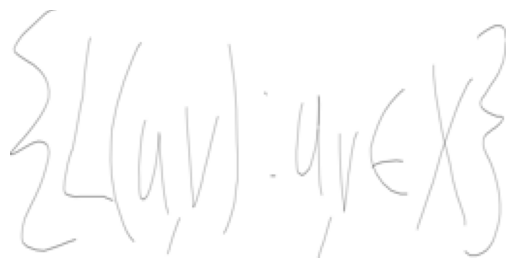

original size:  (1389, 373)
resized size:  (256, 128)


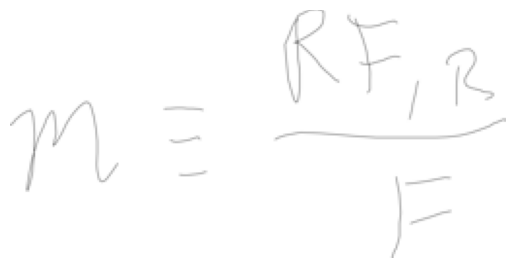

original size:  (904, 463)
resized size:  (256, 128)


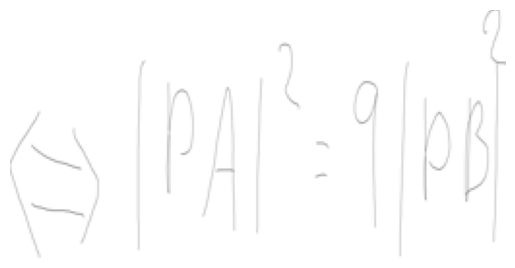

original size:  (1649, 388)
resized size:  (256, 128)


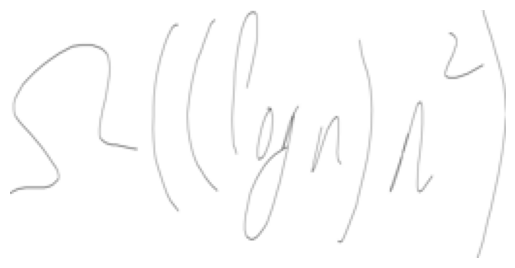

original size:  (1158, 297)
resized size:  (256, 128)


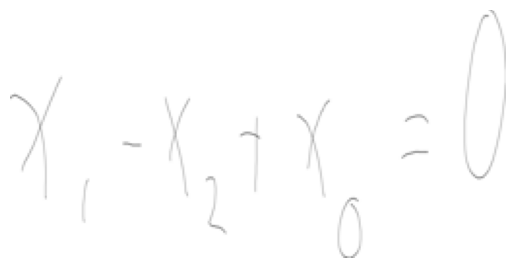

original size:  (1455, 289)
resized size:  (256, 128)


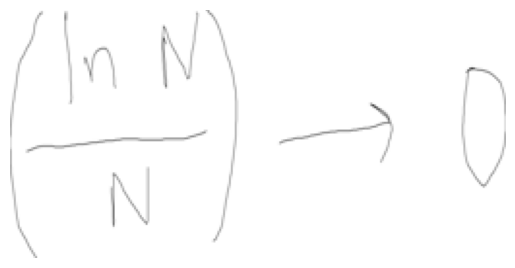

original size:  (885, 278)
resized size:  (256, 128)


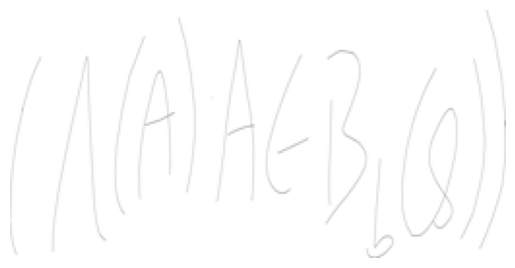

original size:  (2279, 546)
resized size:  (256, 128)


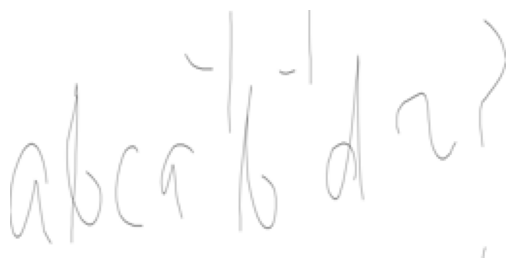

original size:  (1173, 286)
resized size:  (256, 128)


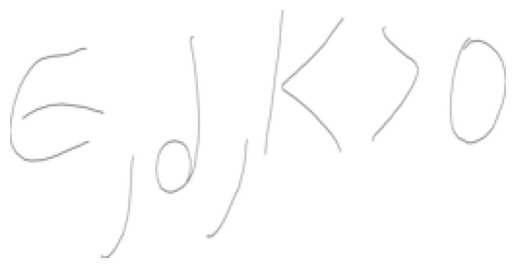

original size:  (1060, 300)
resized size:  (256, 128)


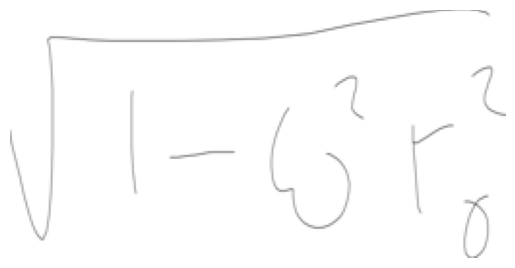

original size:  (827, 282)
resized size:  (256, 128)


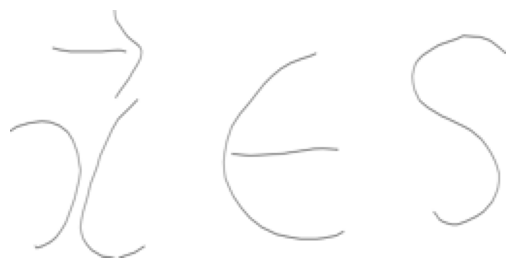

original size:  (859, 275)
resized size:  (256, 128)


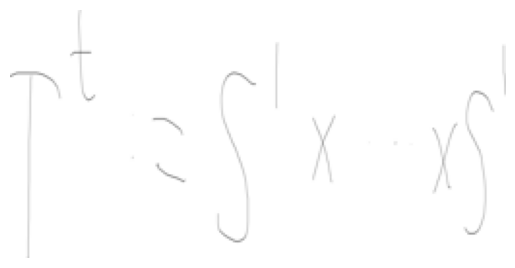

original size:  (1605, 315)
resized size:  (256, 128)


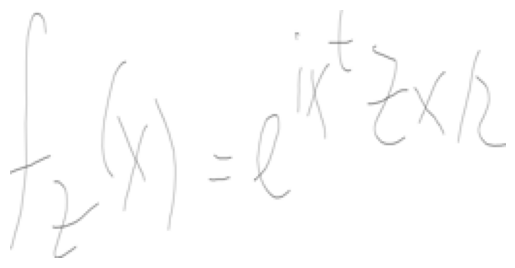

original size:  (1404, 310)
resized size:  (256, 128)


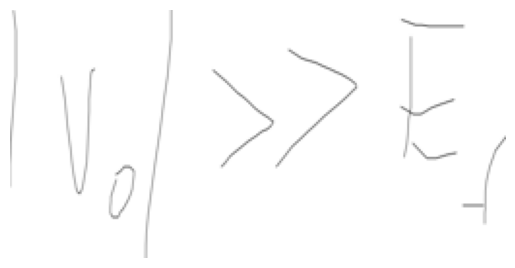

original size:  (840, 232)
resized size:  (256, 128)


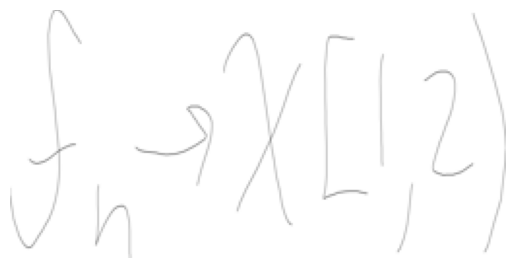

original size:  (1255, 335)
resized size:  (256, 128)


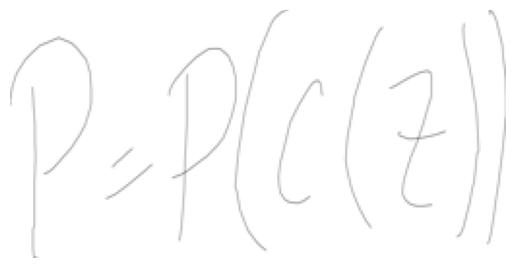

original size:  (1032, 389)
resized size:  (256, 128)


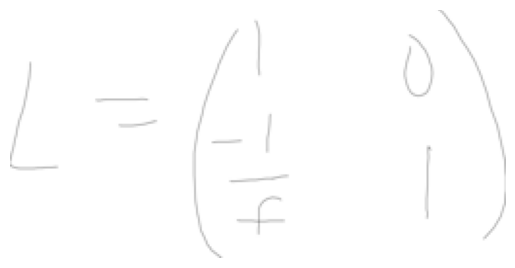

original size:  (1050, 495)
resized size:  (256, 128)


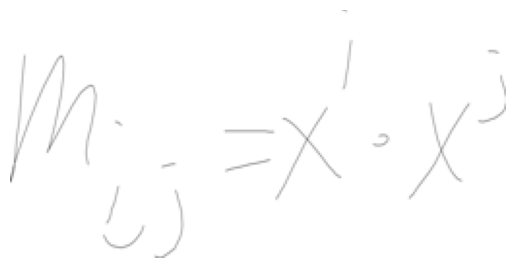

original size:  (980, 371)
resized size:  (256, 128)


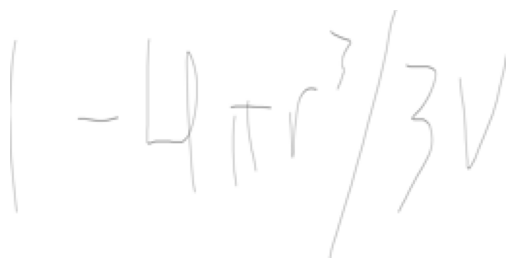

original size:  (1478, 363)
resized size:  (256, 128)


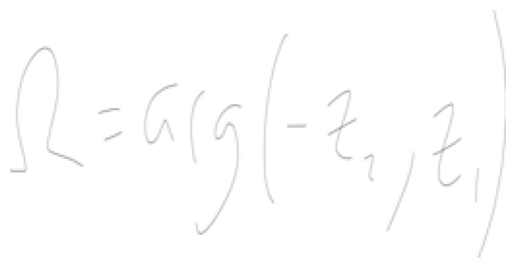

original size:  (1648, 398)
resized size:  (256, 128)


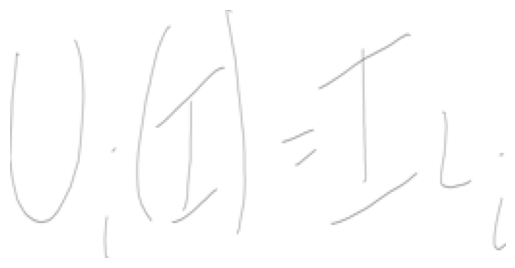

original size:  (1177, 391)
resized size:  (256, 128)


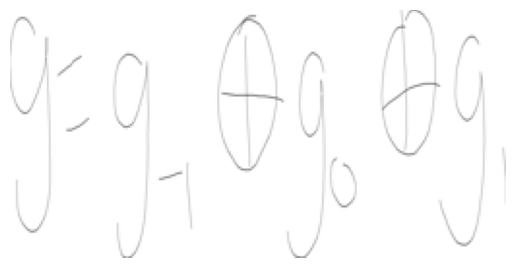

original size:  (1620, 280)
resized size:  (256, 128)


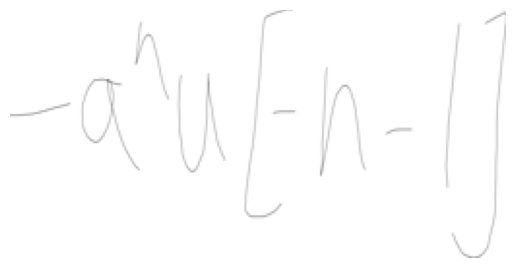

original size:  (1289, 403)
resized size:  (256, 128)


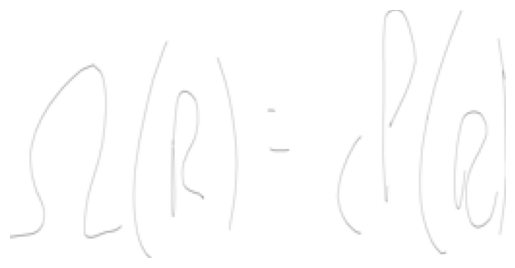

original size:  (2115, 445)
resized size:  (256, 128)


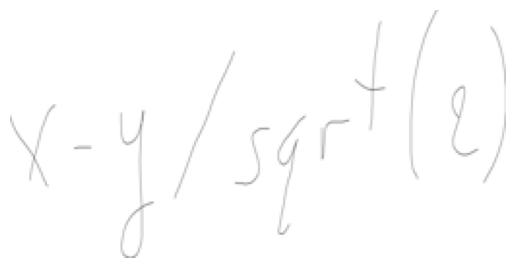

original size:  (1211, 333)
resized size:  (256, 128)


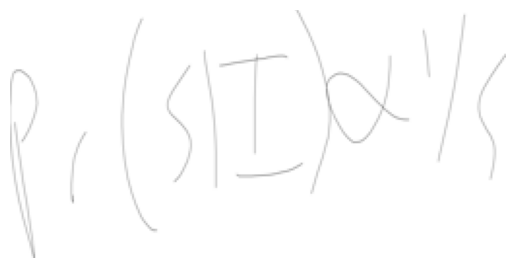

original size:  (1313, 441)
resized size:  (256, 128)


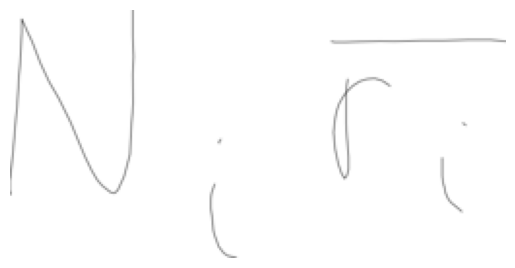

original size:  (630, 323)
resized size:  (256, 128)


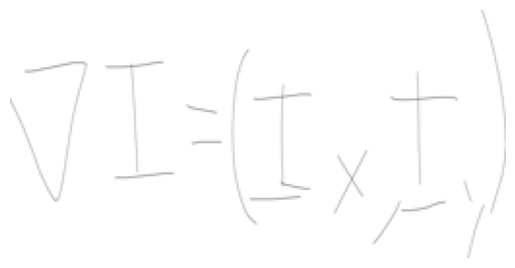

original size:  (1426, 403)
resized size:  (256, 128)


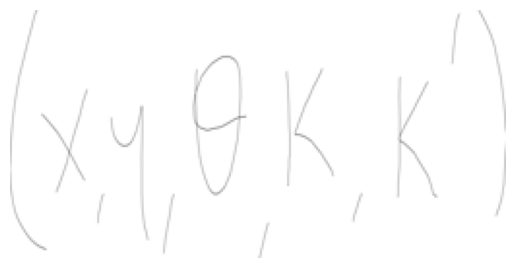

original size:  (1306, 355)
resized size:  (256, 128)


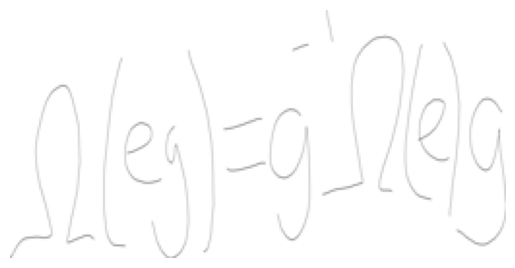

original size:  (1650, 367)
resized size:  (256, 128)


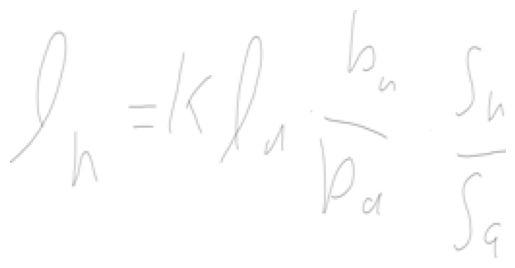

original size:  (1430, 466)
resized size:  (256, 128)


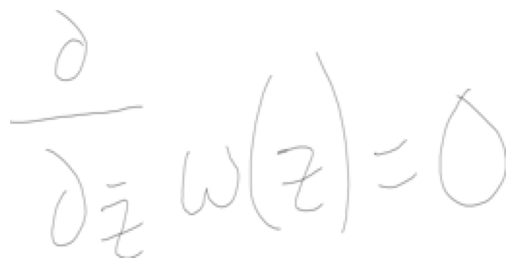

original size:  (1094, 395)
resized size:  (256, 128)


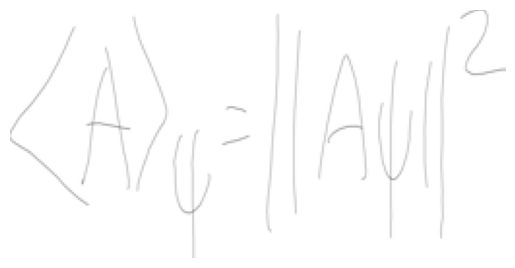

original size:  (1361, 416)
resized size:  (256, 128)


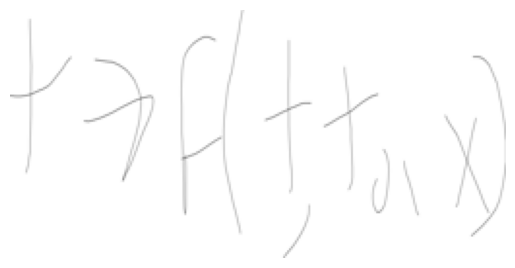

original size:  (1325, 365)
resized size:  (256, 128)


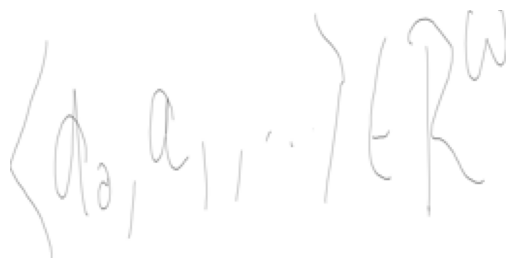

original size:  (1475, 316)
resized size:  (256, 128)


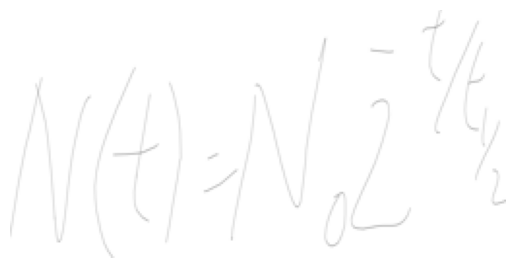

original size:  (2337, 562)
resized size:  (256, 128)


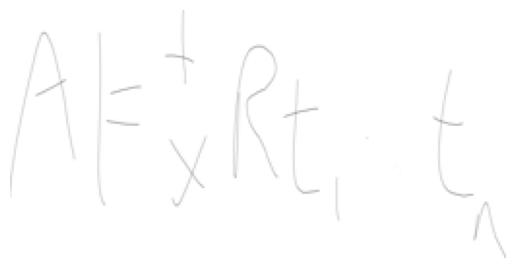

original size:  (1882, 464)
resized size:  (256, 128)


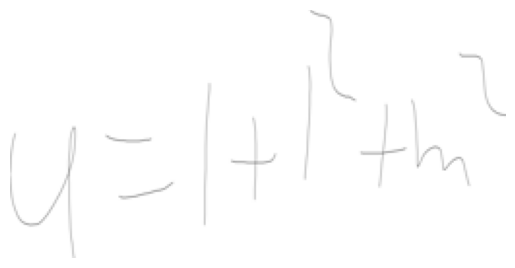

original size:  (1315, 392)
resized size:  (256, 128)


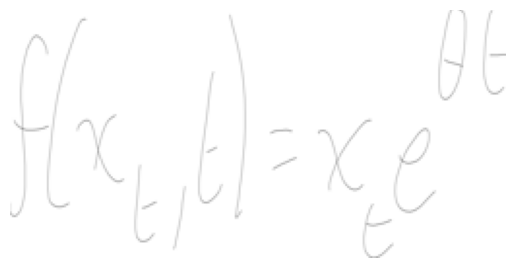

original size:  (1574, 463)
resized size:  (256, 128)


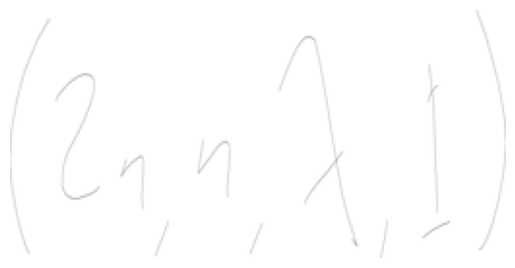

original size:  (1996, 494)
resized size:  (256, 128)


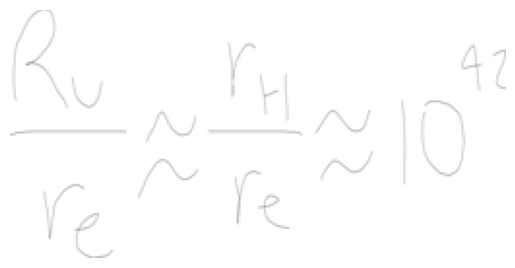

original size:  (1579, 525)
resized size:  (256, 128)


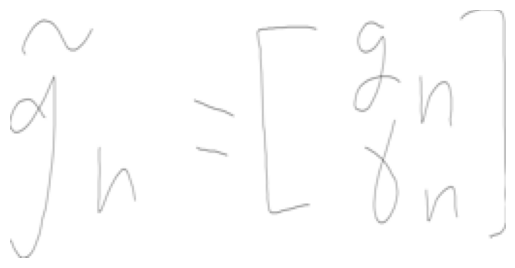

original size:  (1046, 347)
resized size:  (256, 128)


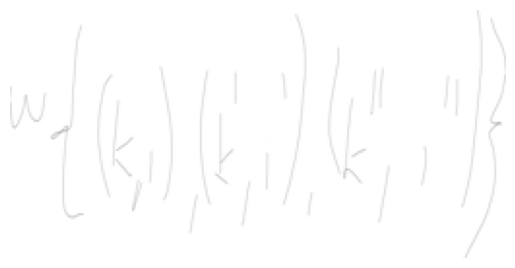

original size:  (2249, 645)
resized size:  (256, 128)


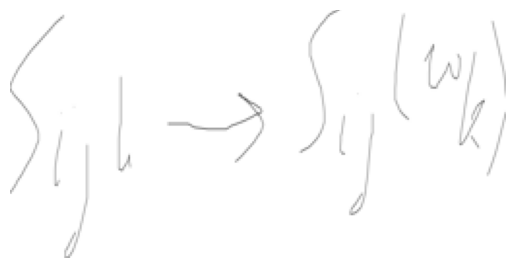

original size:  (1050, 282)
resized size:  (256, 128)


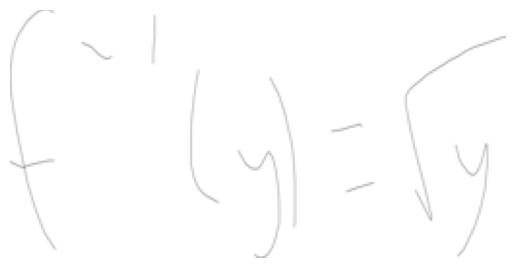

original size:  (1271, 458)
resized size:  (256, 128)


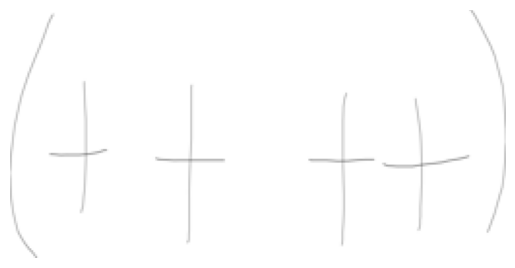

original size:  (1184, 367)
resized size:  (256, 128)


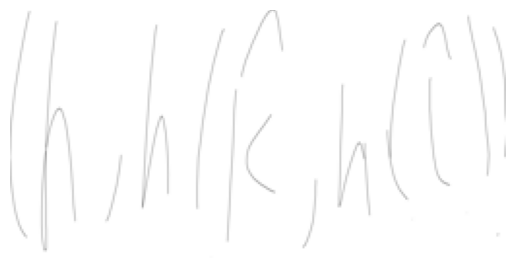

original size:  (1362, 419)
resized size:  (256, 128)


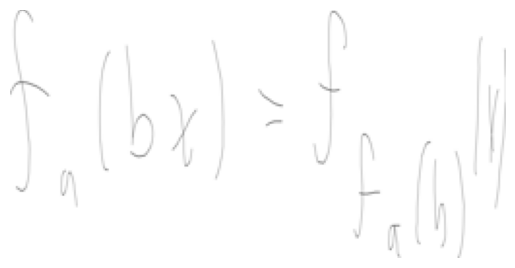

original size:  (1541, 299)
resized size:  (256, 128)


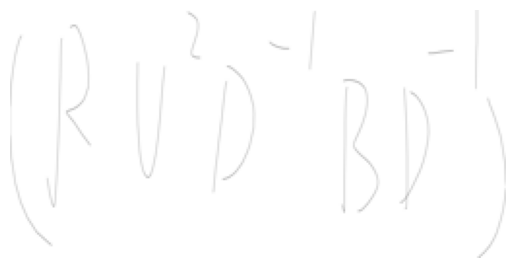

original size:  (2063, 568)
resized size:  (256, 128)


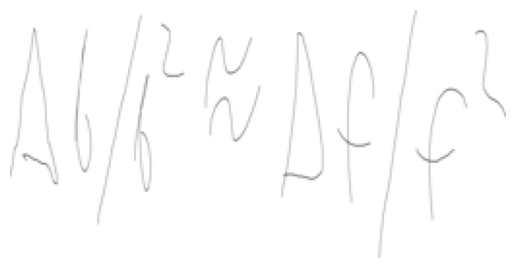

original size:  (1330, 268)
resized size:  (256, 128)


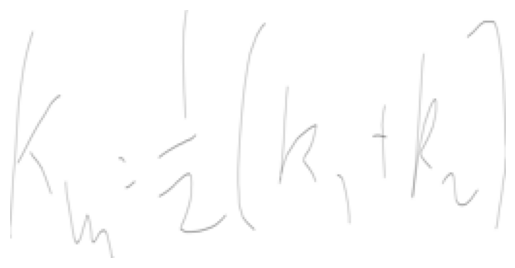

original size:  (1589, 372)
resized size:  (256, 128)


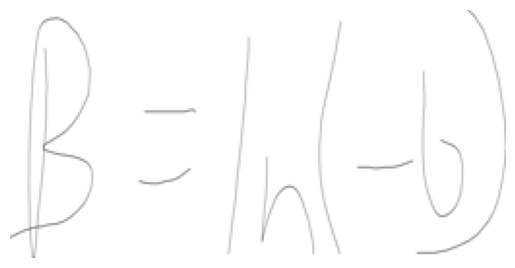

original size:  (1133, 291)
resized size:  (256, 128)


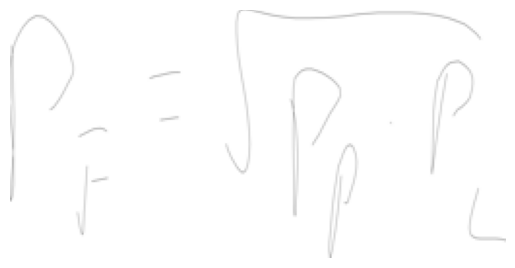

original size:  (1644, 539)
resized size:  (256, 128)


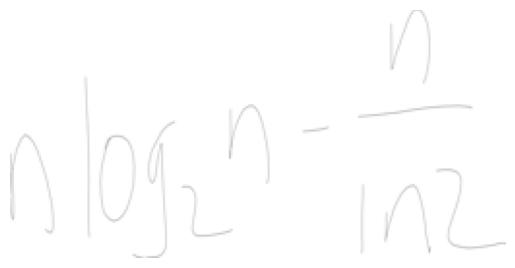

original size:  (1841, 630)
resized size:  (256, 128)


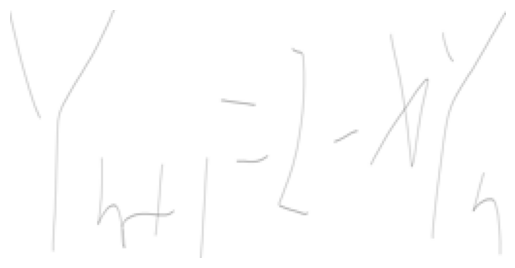

original size:  (1784, 463)
resized size:  (256, 128)


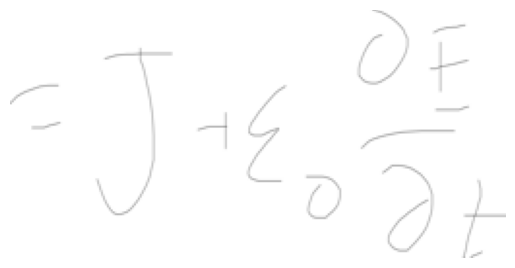

original size:  (1157, 448)
resized size:  (256, 128)


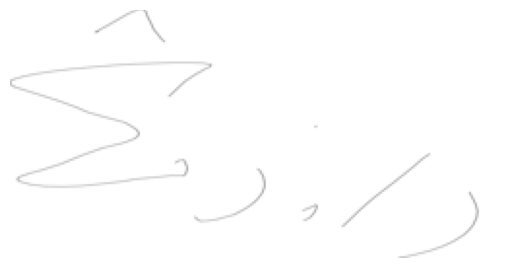

original size:  (760, 727)
resized size:  (256, 128)


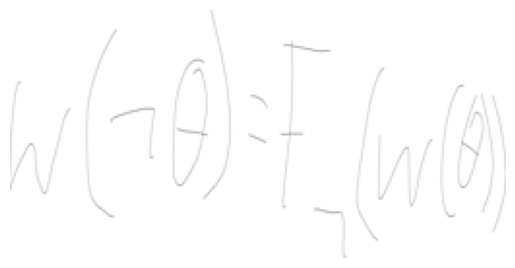

original size:  (2051, 455)
resized size:  (256, 128)


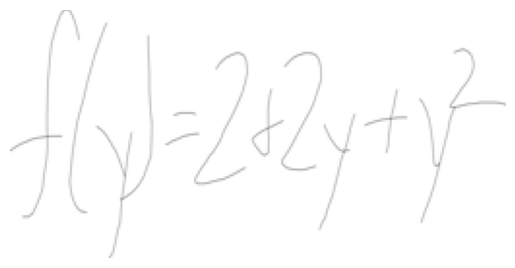

original size:  (1178, 429)
resized size:  (256, 128)


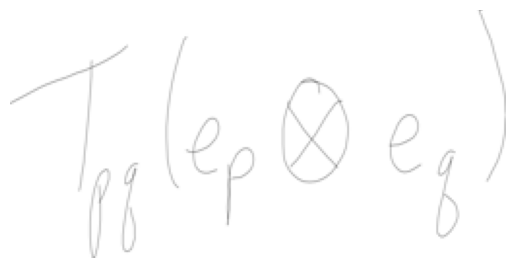

original size:  (1213, 482)
resized size:  (256, 128)


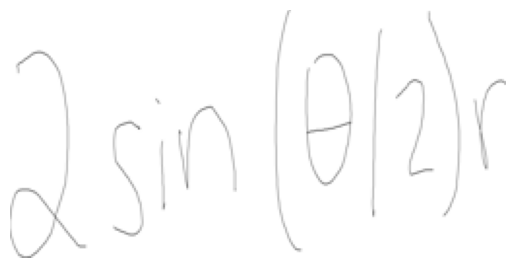

original size:  (1019, 277)
resized size:  (256, 128)


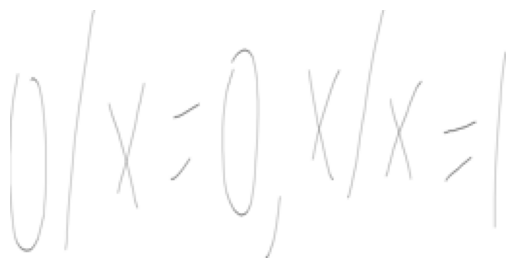

original size:  (1506, 268)
resized size:  (256, 128)


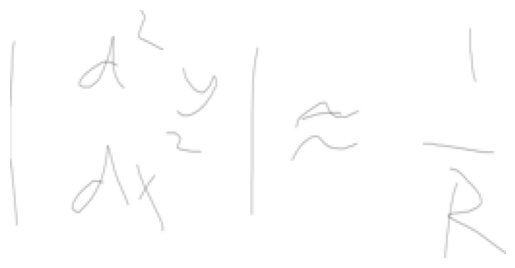

original size:  (1341, 540)
resized size:  (256, 128)


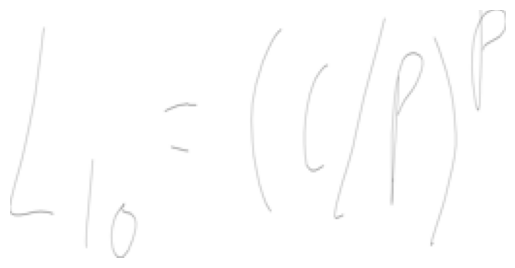

original size:  (1780, 428)
resized size:  (256, 128)


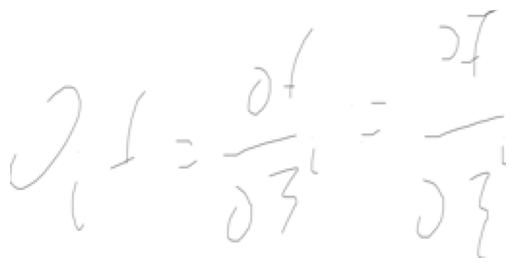

original size:  (1181, 392)
resized size:  (256, 128)


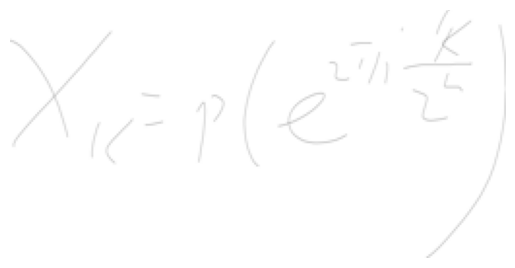

original size:  (2021, 760)
resized size:  (256, 128)


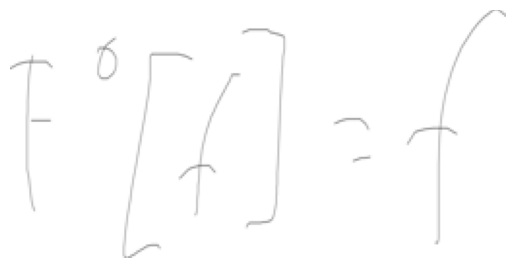

original size:  (1097, 326)
resized size:  (256, 128)


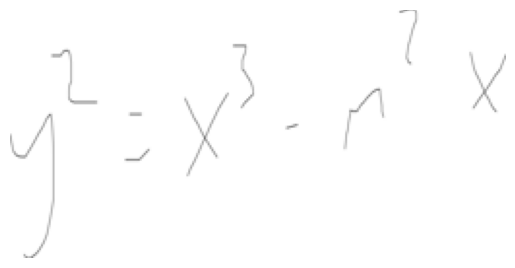

original size:  (924, 251)
resized size:  (256, 128)


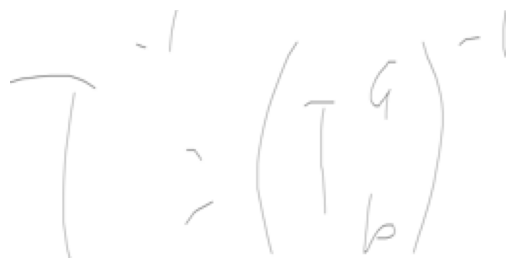

original size:  (1278, 339)
resized size:  (256, 128)


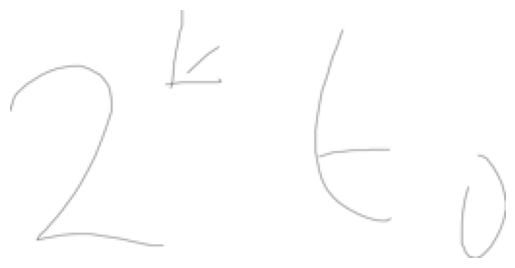

original size:  (844, 455)
resized size:  (256, 128)


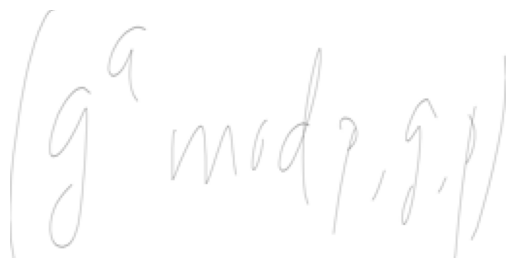

original size:  (1639, 452)
resized size:  (256, 128)


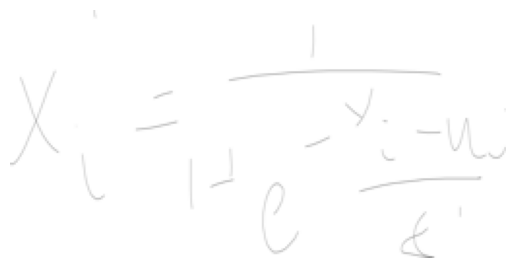

original size:  (2031, 576)
resized size:  (256, 128)


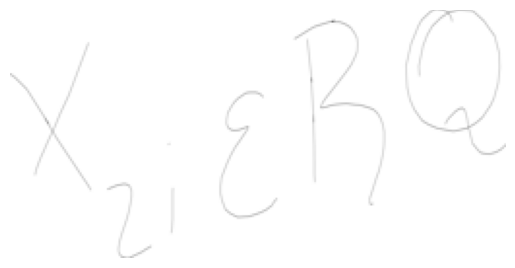

original size:  (1897, 558)
resized size:  (256, 128)


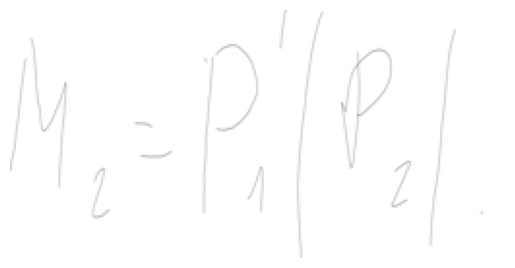

original size:  (1542, 494)
resized size:  (256, 128)


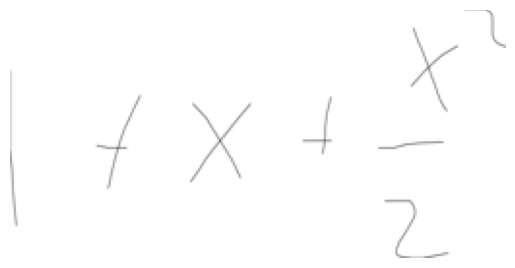

original size:  (697, 310)
resized size:  (256, 128)


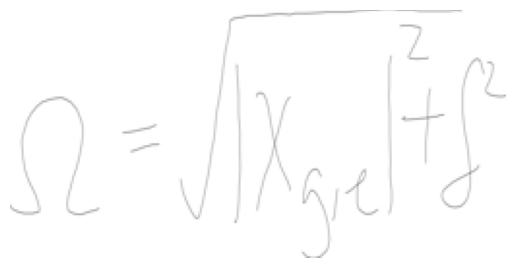

original size:  (1293, 407)
resized size:  (256, 128)


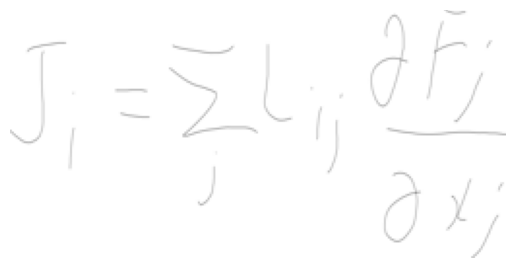

original size:  (1395, 477)
resized size:  (256, 128)


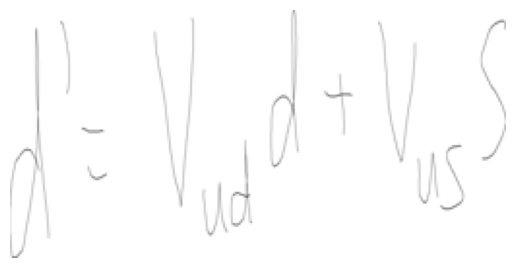

original size:  (1280, 248)
resized size:  (256, 128)


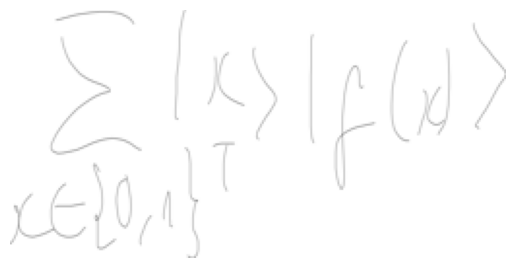

original size:  (1337, 450)
resized size:  (256, 128)


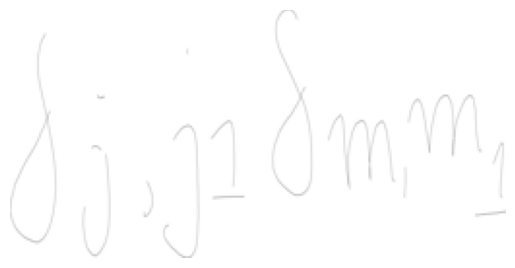

original size:  (2171, 604)
resized size:  (256, 128)


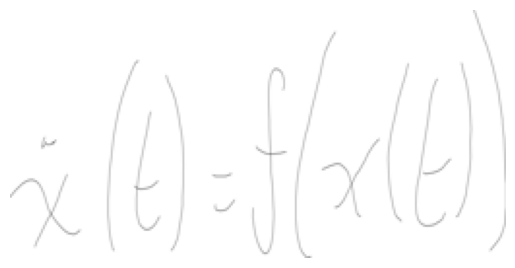

original size:  (1279, 402)
resized size:  (256, 128)


In [13]:
process_dir(path+'test/', path+'test-images/')